In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.__version__

'0.12.0'

In [3]:
pd.__version__

'1.3.4'

In [4]:
# perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240612/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_fnn_2l_lr1e-4/aligned_msl2048/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [11]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        print(df.head())
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        df["orig_y_pred"] = orig_pred_class
        df["new_y_pred"] = df[classes].idxmax(axis=1)
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [12]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [13]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [14]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
      Human         1         2         3         4         5         6  \
0  0.000021  0.000408  0.023282  0.000002  0.000056  0.000034  0.944711   
1  0.000022  0.000409  0.023270  0.000002  0.000059  0.000036  0.943135   
2  0.000018  0.000325  0.020857  0.000002  0.000056  0.000038  0.939987   
3  0.000021  0.000408  0.023282  0.000002  0.000056  0.000034  0.944711   
4  0.000022  0.000482  0.022938  0.000002  0.000068  0.000038  0.939452   

          7          uniref90_id y_true orig_token  perturb_pos new_token  
0  0.031486  UniRef90_A0A7T6Y5W2  Human          T         2140         D  
1  0.033067  UniRef90_A0A7T6Y5W2  Human          N         2021         W  
2  0.038716  UniRef90_A0A7T6Y5W2  Human          P          790         W  
3  0.031486  UniRef90_A0A7T6Y5W2  Human          L         2222         Z  
4  0.036998  UniRef90_A0A7T6Y5W2  Human          Y          431         B  


KeyError: "['Cat', 'Chicken', 'Chinese rufous horseshoe bat', 'Ferret', 'Gray wolf', 'Horshoe bat', 'Pig'] not in index"


#### WIV04 reference sequence

In [11]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

uniref90_id                                        aligned_seq  \
0       WIV04  --------------MFVFLVLLPLVSS--------Q----------...   

                                                 seq  \
0  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                    virus_name virus_host_name  \
0  WIV04(MN996528.1) Wuhan variant index virus    homo sapiens   

  human_binary_label  
0       homo sapiens

In [15]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [13]:
wiv04_aligned_seq[:1367]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [14]:
wiv04_aligned_seq[1367:]

'--------------------------------NGVGYQPY-------------------RVVVLSFE----LLHAPA---TVCG---------------------------------PKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPF-----------------QQFGRDIADTTDAV--RDPQTLEILDITPCSFGGVSVITP-----GTNTSNQVAVLYQDVNCTEVPVAI-------HADQLTPTWRVYSTGS--NVFQTRAGCLIGAEHVN--NSYECDIPI----GAGICASYQTQTN-SPRRARSVASQSIIAYTMSLGAENSVAYSNN---------SIAIPTNFTISVTTEILPVSMTKTSVD-CTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQI--YKTPPIKDF-----------------GGF-------NFSQILPDPSK-----PSKRSFIEDLLFNKVTLADAGFIKQ-YGDCLGDI---AARDLICAQKFNGLTVLPPLLTD-EM-IAQYTSALLAGTITSGWTFG--AGAAL-QIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKI--------------QDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLND--ILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFC-GKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---------HDGKAHFPRE---GVFVS-----NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPEL----DSFKEELDKYFKNHTSPDVDLGDIS-GINASV--VNIQKEID--------------RLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCMTS-----CCS-----------CLKG

In [11]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [12]:
perturbed_output_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
0      0.000487  0.000990                      0.200292  0.007629   0.002347   
1      0.000473  0.000935                      0.201658  0.007580   0.002251   
2      0.000487  0.000990                      0.200292  0.007629   0.002347   
3      0.000487  0.000990                      0.200292  0.007629   0.002347   
4      0.000554  0.001020                      0.199196  0.008695   0.002662   
...         ...       ...                           ...       ...        ...   
31821  0.000054  0.003629                      0.020363  0.000152   0.000562   
31822  0.000054  0.003629                      0.020363  0.000152   0.000562   
31823  0.000054  0.003624                      0.020782  0.000155   0.000568   
31824  0.000054  0.003629                      0.020363  0.000152   0.000562   
31825  0.000053  0.003756                      0.018258  0.000141   0.000562   

       Horshoe bat     Human       Pig          uniref90_id y_true orig_token  \
0         0.025633  0.439901  0.322721  UniRef90_A0A8B6RCH8  Human          C   
1         0.025524  0.433583  0.327997  UniRef90_A0A8B6RCH8  Human          K   
2         0.025633  0.439901  0.322721  UniRef90_A0A8B6RCH8  Human          E   
3         0.025633  0.439901  0.322721  UniRef90_A0A8B6RCH8  Human          A   
4         0.026524  0.414257  0.347091  UniRef90_A0A8B6RCH8  Human          S   
...            ...       ...       ...                  ...    ...        ...   
31821     0.000812  0.960657  0.013770  UniRef90_A0A8B1J2N1  Human          L   
31822     0.000812  0.960657  0.013770  UniRef90_A0A8B1J2N1  Human          S   
31823     0.000831  0.959979  0.014008  UniRef90_A0A8B1J2N1  Human          G   
31824     0.000812  0.960657  0.013770  UniRef90_A0A8B1J2N1  Human          R   
31825     0.000695  0.964001  0.012534  UniRef90_A0A8B1J2N1  Human          P   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
0             2381         X         0.000000             0.000000   
1              461         J        -0.006318             0.006318   
2             1433         R         0.000000             0.000000   
3             1936         L         0.000000             0.000000   
4              709         R        -0.025644             0.025644   
...            ...       ...              ...                  ...   
31821         1509         J         0.000000             0.000000   
31822         1512         W         0.000000             0.000000   
31823          988         J        -0.000678             0.000678   
31824         1622         P         0.000000             0.000000   
31825         1086         U         0.003344             0.003344   

      orig_y_pred new_y_pred  perturb_seq_pos  
0           Human      Human             1250  
1           Human      Human              187  
2           Human      Human              516  
3           Human      Human              890  
4           Human      Human              247  
...           ...        ...              ...  
31821       Human      Human              552  
31822       Human      Human              555  
31823       Human      Human              381  
31824       Human      Human              634  
31825       Human      Human              412  

[2978369 rows x 18 columns]

In [13]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [14]:
perturbed_output_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
0      0.000487  0.000990                      0.200292  0.007629   0.002347   
1      0.000473  0.000935                      0.201658  0.007580   0.002251   
2      0.000487  0.000990                      0.200292  0.007629   0.002347   
3      0.000487  0.000990                      0.200292  0.007629   0.002347   
4      0.000554  0.001020                      0.199196  0.008695   0.002662   
...         ...       ...                           ...       ...        ...   
31821  0.000054  0.003629                      0.020363  0.000152   0.000562   
31822  0.000054  0.003629                      0.020363  0.000152   0.000562   
31823  0.000054  0.003624                      0.020782  0.000155   0.000568   
31824  0.000054  0.003629                      0.020363  0.000152   0.000562   
31825  0.000053  0.003756                      0.018258  0.000141   0.000562   

       Horshoe bat     Human       Pig          uniref90_id y_true orig_token  \
0         0.025633  0.439901  0.322721  UniRef90_A0A8B6RCH8  Human          C   
1         0.025524  0.433583  0.327997  UniRef90_A0A8B6RCH8  Human          K   
2         0.025633  0.439901  0.322721  UniRef90_A0A8B6RCH8  Human          E   
3         0.025633  0.439901  0.322721  UniRef90_A0A8B6RCH8  Human          A   
4         0.026524  0.414257  0.347091  UniRef90_A0A8B6RCH8  Human          S   
...            ...       ...       ...                  ...    ...        ...   
31821     0.000812  0.960657  0.013770  UniRef90_A0A8B1J2N1  Human          L   
31822     0.000812  0.960657  0.013770  UniRef90_A0A8B1J2N1  Human          S   
31823     0.000831  0.959979  0.014008  UniRef90_A0A8B1J2N1  Human          G   
31824     0.000812  0.960657  0.013770  UniRef90_A0A8B1J2N1  Human          R   
31825     0.000695  0.964001  0.012534  UniRef90_A0A8B1J2N1  Human          P   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
0             2381         X         0.000000             0.000000   
1              461         J        -0.006318             0.006318   
2             1433         R         0.000000             0.000000   
3             1936         L         0.000000             0.000000   
4              709         R        -0.025644             0.025644   
...            ...       ...              ...                  ...   
31821         1509         J         0.000000             0.000000   
31822         1512         W         0.000000             0.000000   
31823          988         J        -0.000678             0.000678   
31824         1622         P         0.000000             0.000000   
31825         1086         U         0.003344             0.003344   

      orig_y_pred new_y_pred  perturb_seq_pos  
0           Human      Human             1250  
1           Human      Human              187  
2           Human      Human              516  
3           Human      Human              890  
4           Human      Human              247  
...           ...        ...              ...  
31821       Human      Human              552  
31822       Human      Human              555  
31823       Human      Human              381  
31824       Human      Human              634  
31825       Human      Human              412  

[2952919 rows x 18 columns]

# Overview

### Distribution of Human class difference

In [15]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [16]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 3139 (0.10630159513349334)
Distribution of full perturbation output
n=2952919
       start       end    count  percentage
0  -0.635250 -0.566258        5    0.000169
1  -0.566258 -0.497265       36    0.001219
2  -0.497265 -0.428273       86    0.002912
3  -0.428273 -0.359281      120    0.004064
4  -0.359281 -0.290288      177    0.005994
5  -0.290288 -0.221296      210    0.007112
6  -0.221296 -0.152304      404    0.013681
7  -0.152304 -0.083311     1944    0.065833
8  -0.083311 -0.014319    76120    2.577788
9  -0.014319  0.054673  2869572   97.177471
10  0.054673  0.123666     3629    0.122895
11  0.123666  0.192658      393    0.013309
12  0.192658  0.261650      122    0.004132
13  0.261650  0.330643       48    0.001626
14  0.330643  0.399635       22    0.000745
15  0.399635  0.468627       15    0.000508
16  0.468627  0.537619        8    0.000271
17  0.537619  0.606612        1    0.000034
18  0.606612  0.675604        2  

<Figure size 640x480 with 0 Axes>

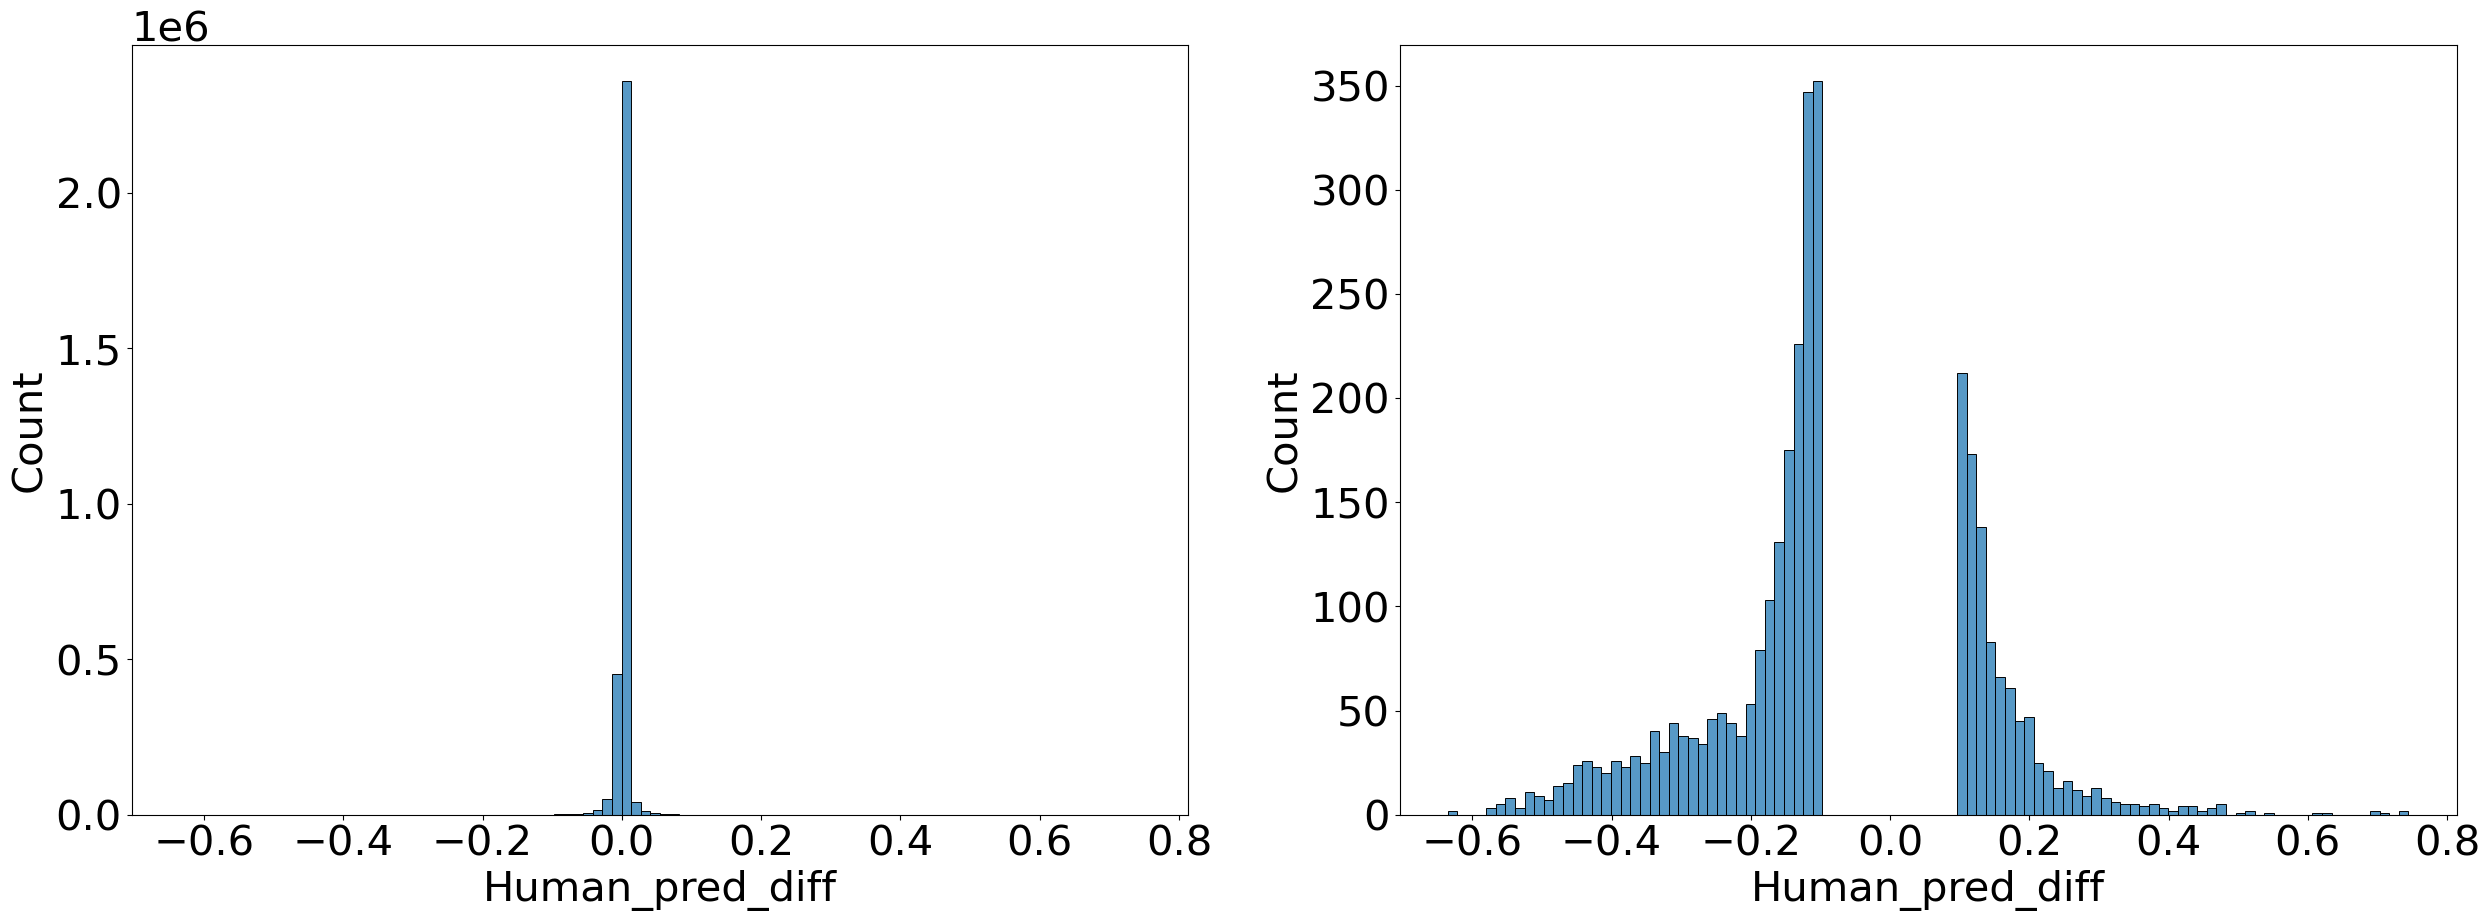

In [17]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

In [18]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

<Figure size 640x480 with 0 Axes>

In [19]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
31824  0.000339  0.002110                      0.057670  0.001883   0.001290   
31825  0.000339  0.002110                      0.057670  0.001883   0.001290   
31824  0.000037  0.002042                      0.036866  0.000159   0.000383   
31825  0.000037  0.002042                      0.036866  0.000159   0.000383   
31824  0.000087  0.000945                      0.316455  0.001591   0.001189   
...         ...       ...                           ...       ...        ...   
30772  0.000948  0.001538                      0.101887  0.008749   0.002986   
30774  0.000948  0.001538                      0.101887  0.008749   0.002986   
30947  0.000652  0.002302                      0.090425  0.005821   0.004104   
30948  0.000652  0.002302                      0.090425  0.005821   0.004104   
30950  0.000652  0.002302                      0.090425  0.005821   0.004104   

       Horshoe bat     Human       Pig          uniref90_id y_true orig_token  \
31824     0.003476  0.842525  0.090706  UniRef90_A0A8B6RF44  Human          S   
31825     0.003476  0.842525  0.090706  UniRef90_A0A8B6RF44  Human          N   
31824     0.002194  0.941868  0.016451  UniRef90_A0A8B1JX30  Human          A   
31825     0.002194  0.941868  0.016451  UniRef90_A0A8B1JX30  Human          L   
31824     0.046121  0.483508  0.150104  UniRef90_A0A8B1JCD7  Human          I   
...            ...       ...       ...                  ...    ...        ...   
30772     0.009851  0.546510  0.327531  UniRef90_A0A8B6RMB3  Human          S   
30774     0.009851  0.546510  0.327531  UniRef90_A0A8B6RMB3  Human          D   
30947     0.007063  0.697490  0.192144  UniRef90_A0A8B6RNC0  Human          I   
30948     0.007063  0.697490  0.192144  UniRef90_A0A8B6RNC0  Human          T   
30950     0.007063  0.697490  0.192144  UniRef90_A0A8B6RNC0  Human          H   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
31824         2246         F    -2.000000e-07         2.000000e-07   
31825         2016         L    -2.000000e-07         2.000000e-07   
31824         2033         J     1.000000e-07         1.000000e-07   
31825         2064         F     1.000000e-07         1.000000e-07   
31824         1777         Z     5.000000e-08         5.000000e-08   
...            ...       ...              ...                  ...   
30772         1688         U    -1.200000e-07         1.200000e-07   
30774         2253         W    -1.200000e-07         1.200000e-07   
30947         1605         Z    -4.000000e-08         4.000000e-08   
30948         1729         S    -4.000000e-08         4.000000e-08   
30950         2156         K    -4.000000e-08         4.000000e-08   

      orig_y_pred new_y_pred  perturb_seq_pos  
31824       Human      Human             1161  
31825       Human      Human              955  
31824       Human      Human              972  
31825       Human      Human             1001  
31824       Human      Human              770  
...           ...        ...              ...  
30772       Human      Human              691  
30774       Human      Human             1168  
30947       Human      Human              624  
30948       Human      Human              723  
30950       Human      Human             1083  

[81 rows x 18 columns]

### Cut-off: mean=0 and variance=0

In [20]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

579

<Figure size 640x480 with 0 Axes>

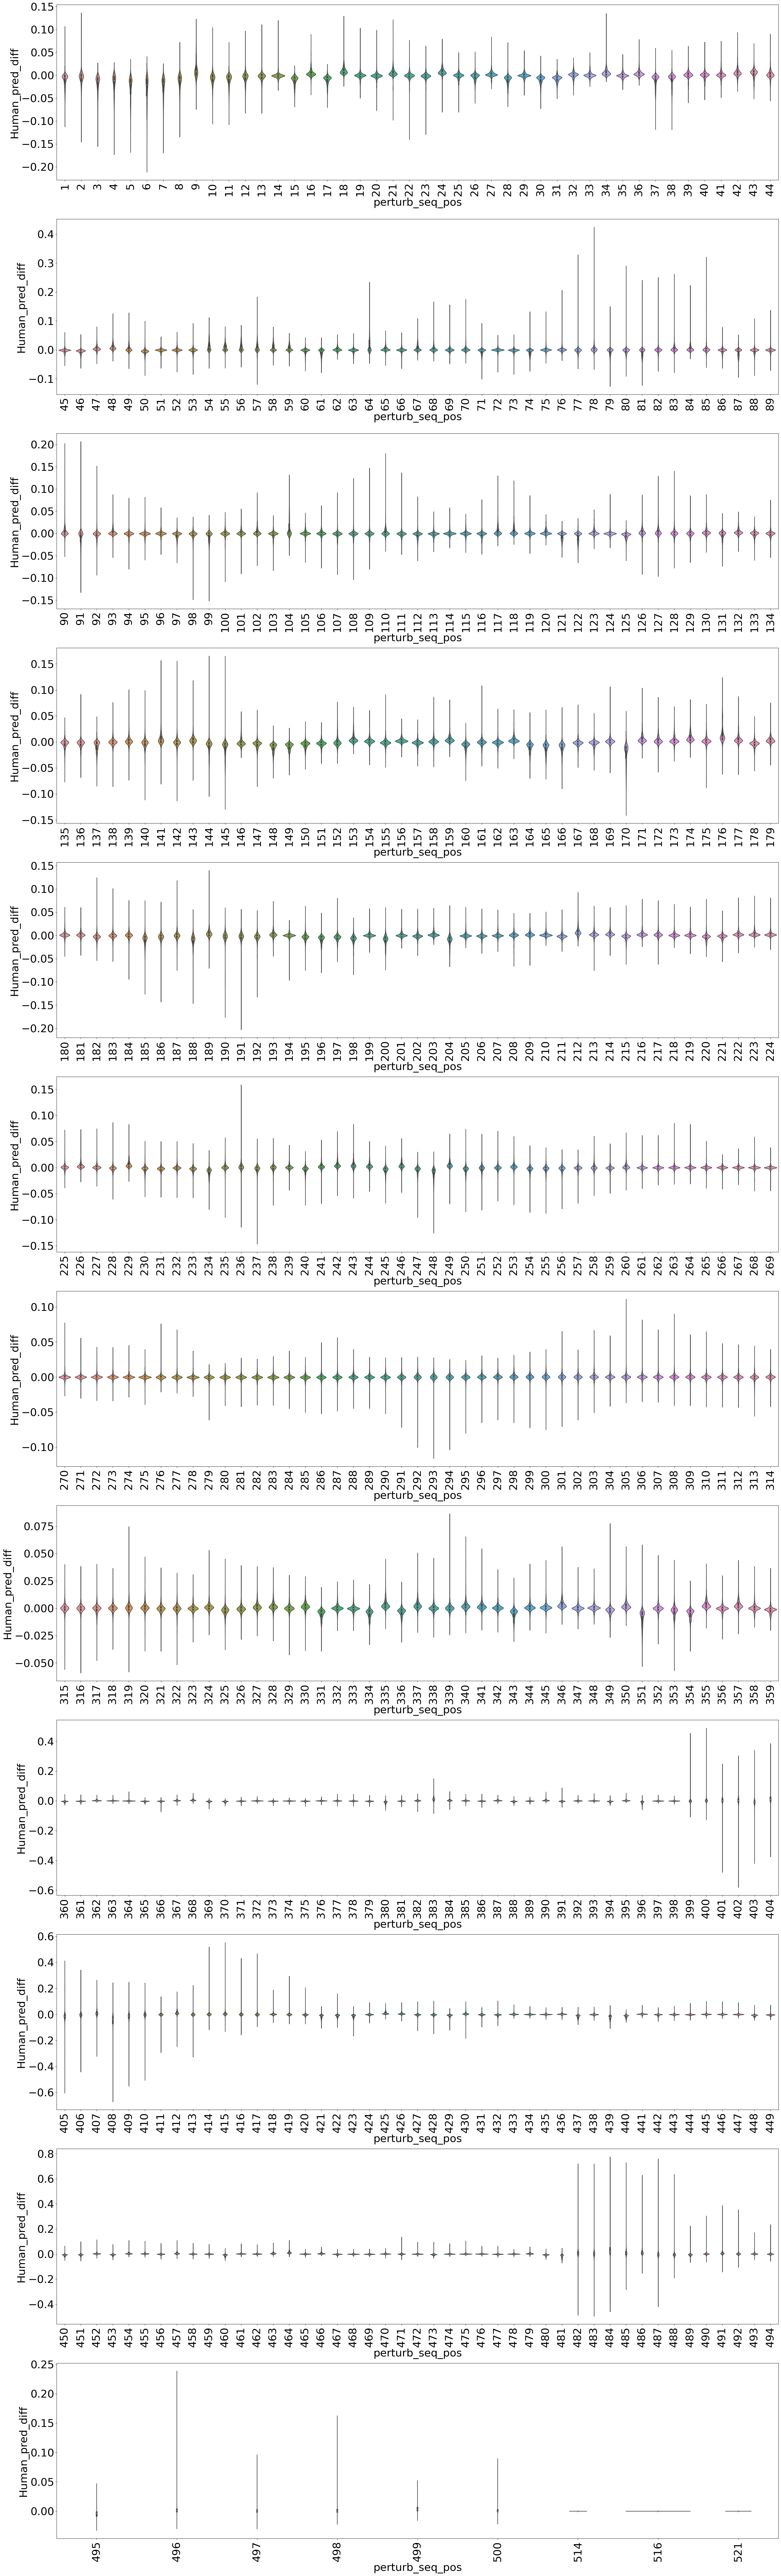

In [57]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 501, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [22]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 579
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 134
1 intersection 2: 134
1 minus 2: 445
2 minus 1: 0
is 2 subset of 1: True


<Figure size 640x480 with 0 Axes>

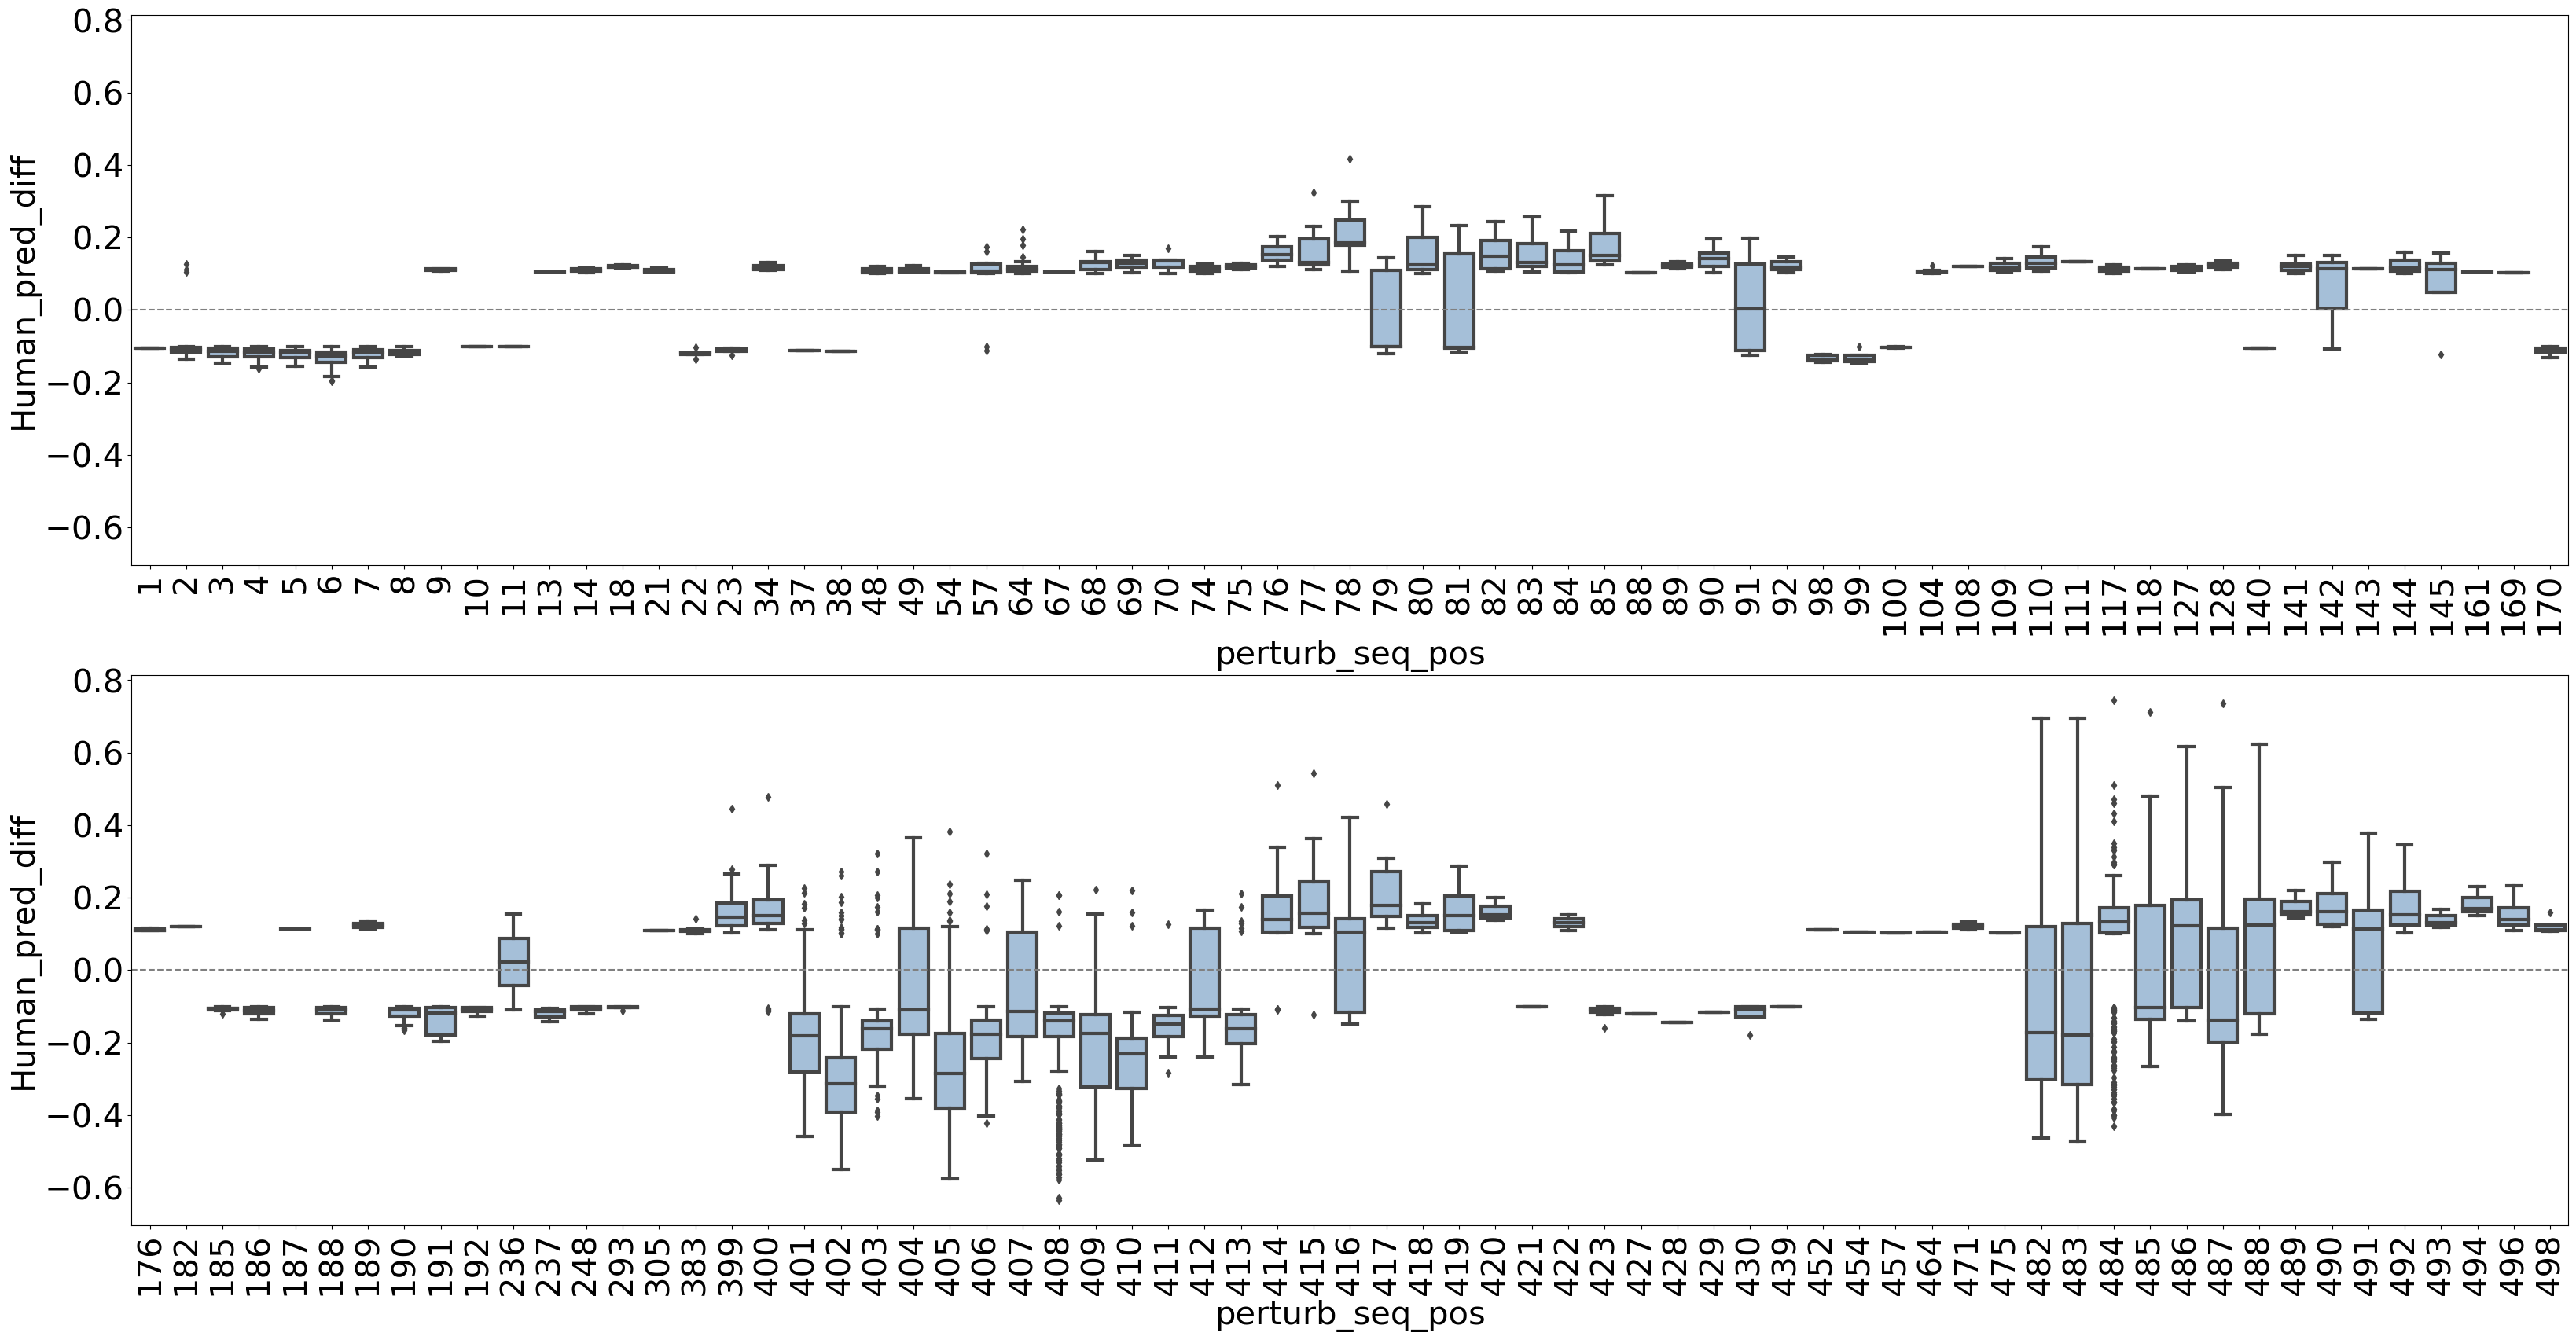

In [58]:
plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"] <= 170],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[0], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[0].tick_params(axis='x', rotation=90)
axs[0].axhline(0.0, color="gray", linestyle="--")
sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"] > 170],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[1], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[1].tick_params(axis='x', rotation=90)
axs[1].axhline(0.0, color="gray", linestyle="--")
#sns.stripplot(data=cut_off_df_2, x="Human_pred_diff", y="perturb_seq_pos", hue="new_token", orient="h", s=10, ax=axs[1], linewidth=1)

plt.show()


### Important positions causing class change from Human

3634
3.907539900935608


<Figure size 640x480 with 0 Axes>

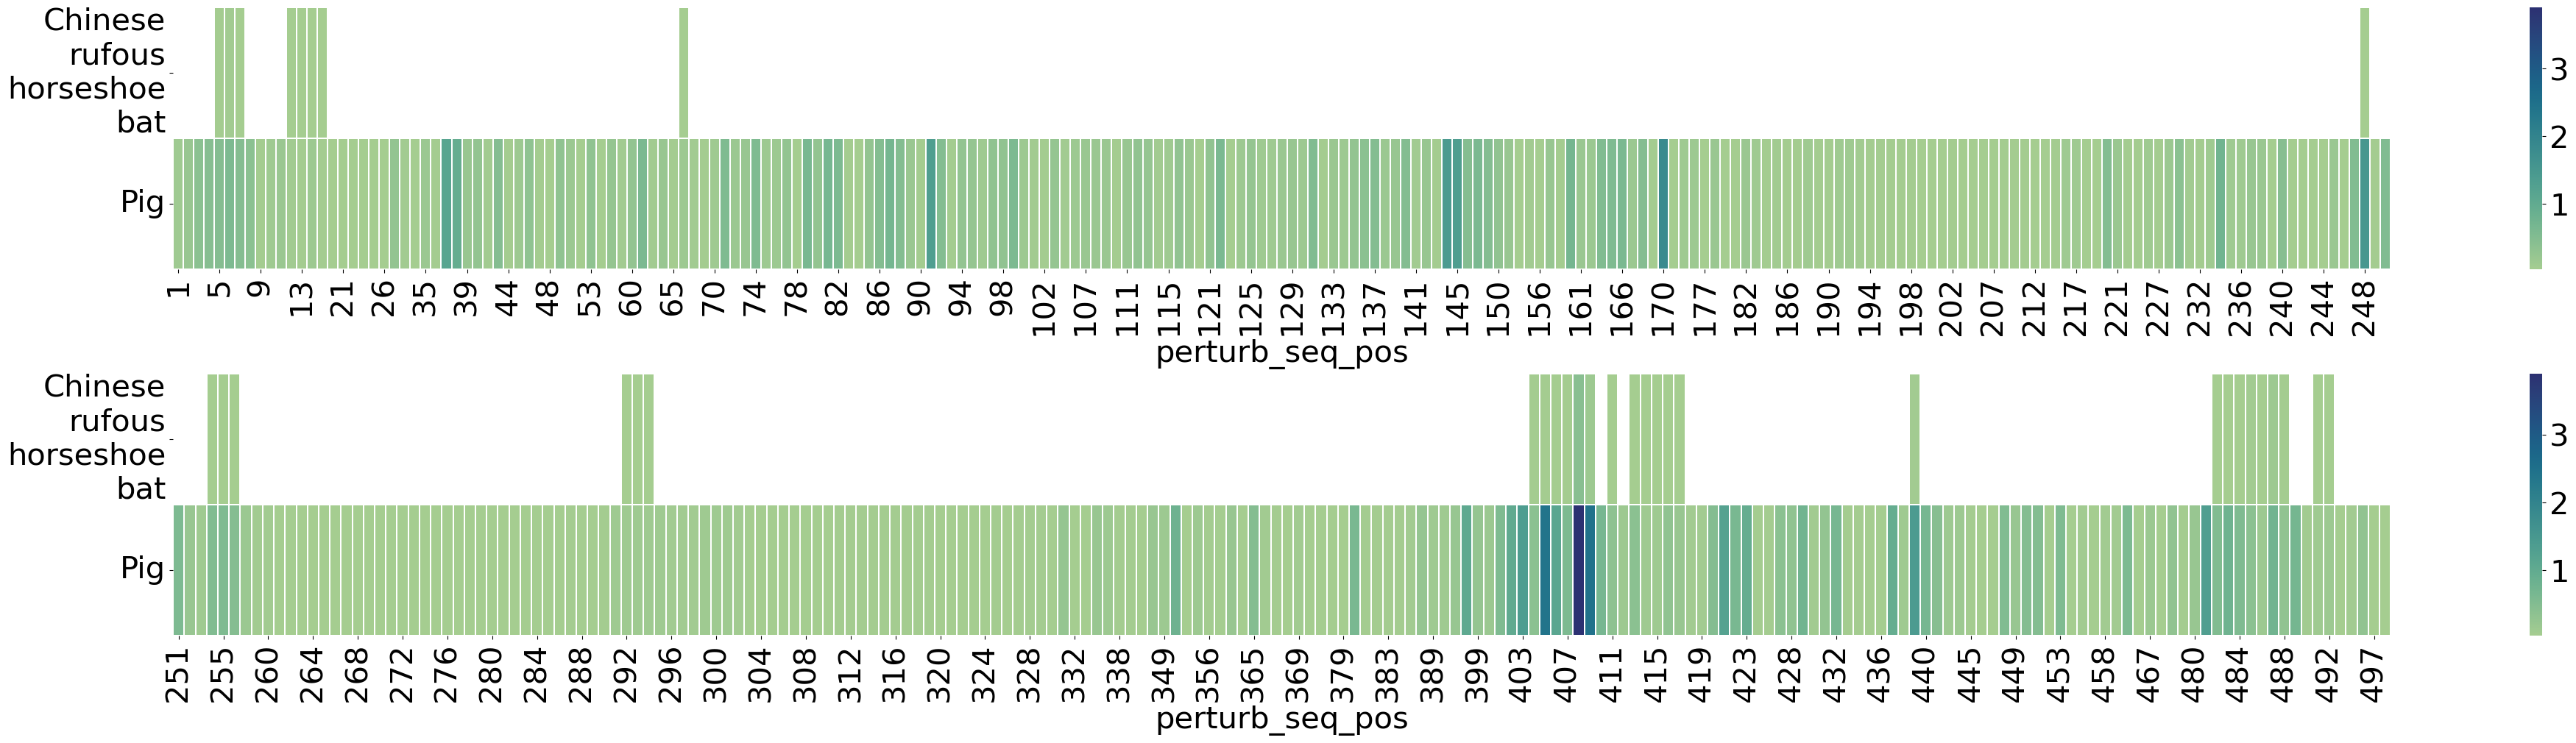

In [24]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 10), sharey=True)
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

sns.heatmap(data=df[df["perturb_seq_pos"] <=250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[0], vmax=max_val)
wrap_yticklabels(axs[0], label_width=10, break_long_words=True)
axs[0].tick_params(axis='x', rotation=90)


sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

489


<Figure size 640x480 with 0 Axes>

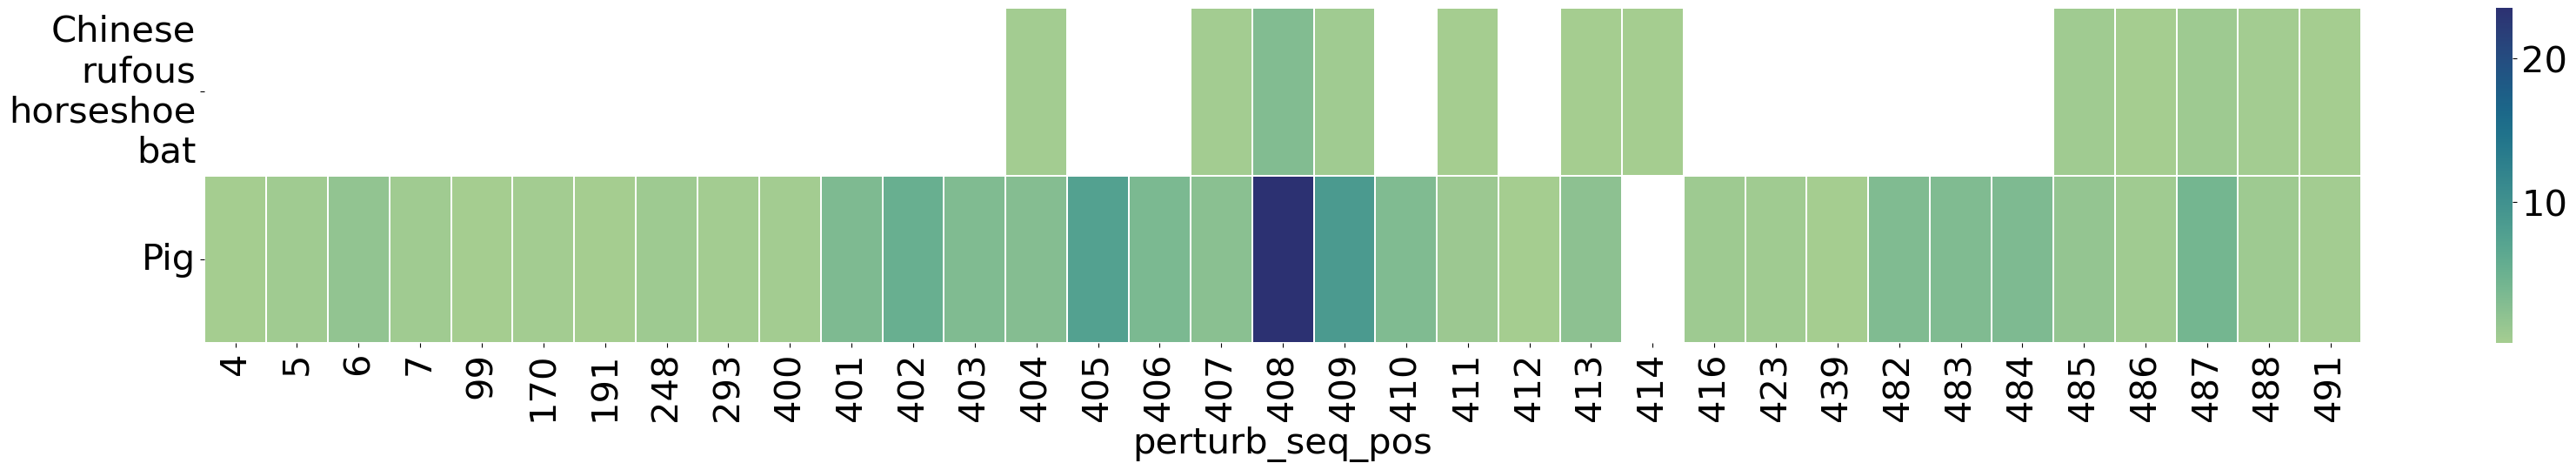

In [25]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(40, 5))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest")
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [26]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_28019/3113693862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


In [27]:
#!pip install textalloc


<Figure size 640x480 with 0 Axes>

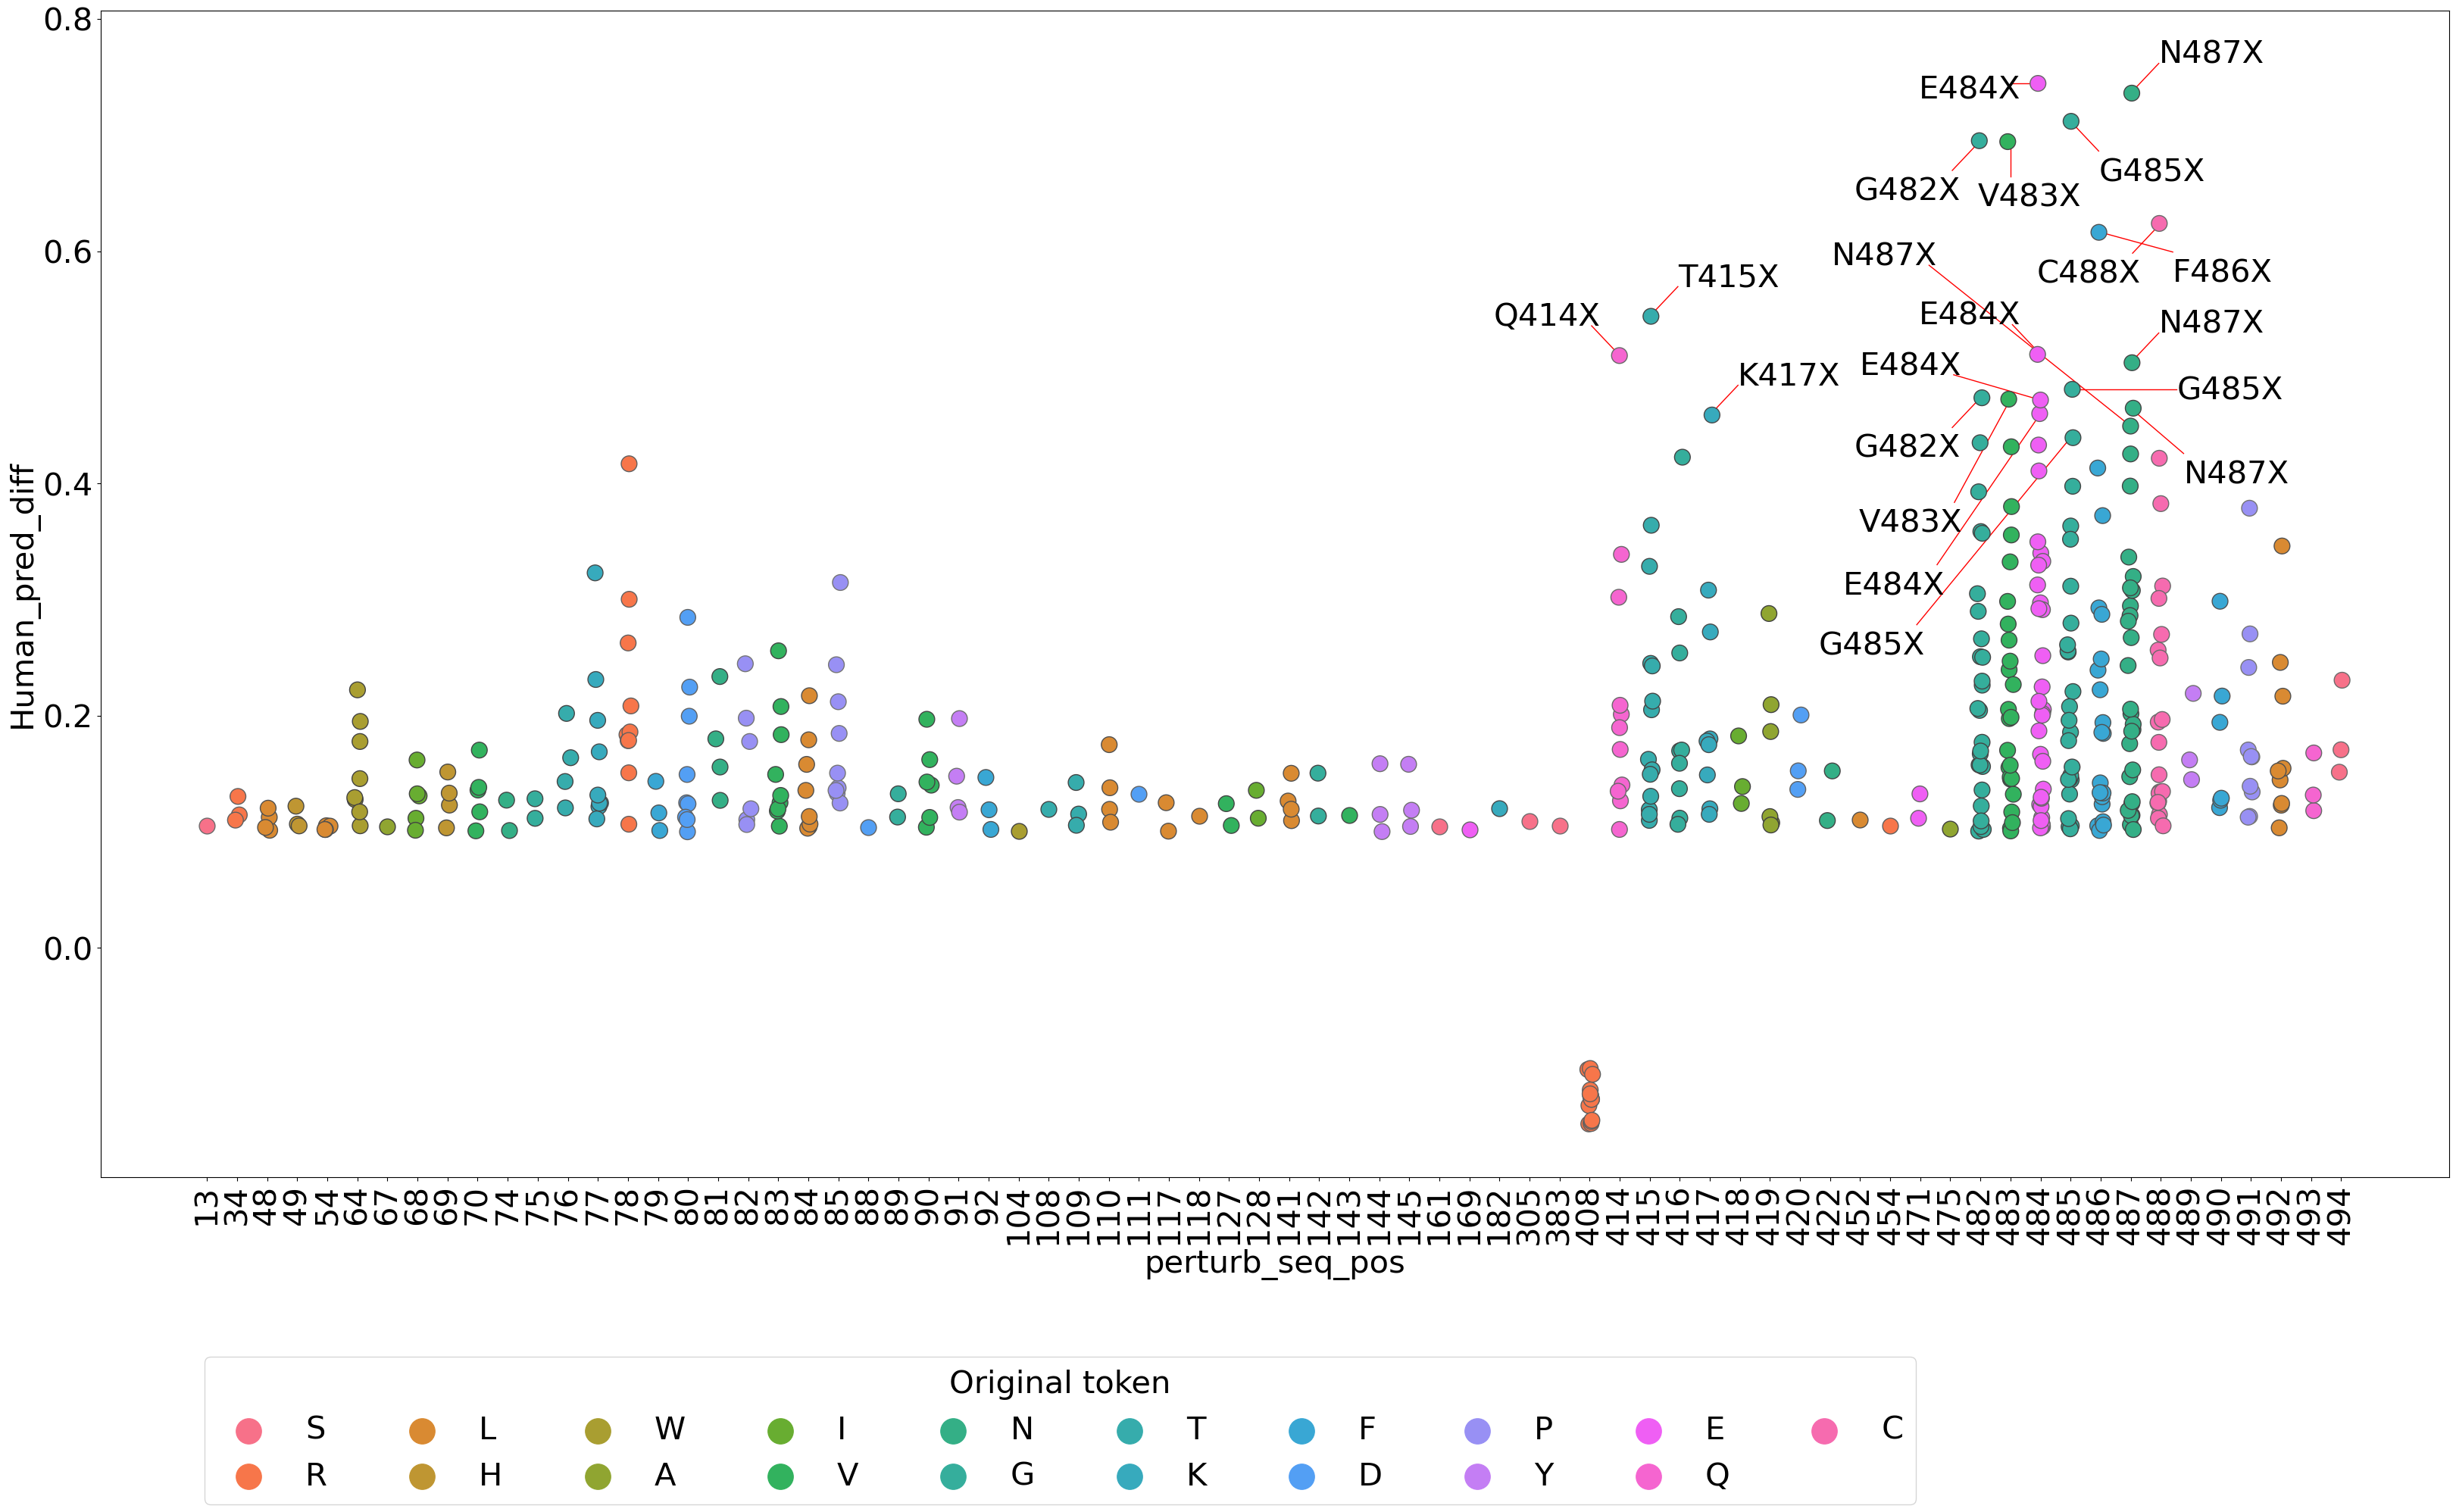

In [28]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [29]:
annotate_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
20452  0.000008  0.001149                      0.036094  0.000041   0.000161   
2469   0.000008  0.001267                      0.042944  0.000045   0.000173   
11762  0.000013  0.001175                      0.060889  0.000085   0.000218   
2347   0.000015  0.001009                      0.073336  0.000112   0.000232   
19340  0.000015  0.001094                      0.074143  0.000107   0.000237   
21498  0.000021  0.001011                      0.127156  0.000202   0.000296   
22658  0.000021  0.001076                      0.131763  0.000204   0.000341   
25758  0.000023  0.000847                      0.181454  0.000288   0.000359   
20401  0.000010  0.001309                      0.031493  0.000055   0.000212   
8519   0.000026  0.000867                      0.202863  0.000349   0.000420   
29381  0.000011  0.001402                      0.037469  0.000058   0.000221   
30256  0.000019  0.001331                      0.053234  0.000119   0.000294   
22836  0.000020  0.001188                      0.058421  0.000136   0.000300   
9728   0.000019  0.001267                      0.059484  0.000131   0.000304   
29999  0.000011  0.001192                      0.032611  0.000065   0.000224   
25488  0.000011  0.001270                      0.038585  0.000067   0.000229   
24434  0.000132  0.001322                      0.049218  0.000847   0.000762   
6355   0.000029  0.000901                      0.236950  0.000410   0.000502   
17270  0.000131  0.001406                      0.057214  0.000865   0.000786   
7761   0.000021  0.001212                      0.055330  0.000145   0.000318   

       Horshoe bat     Human       Pig          uniref90_id y_true orig_token  \
20452     0.003146  0.953277  0.006124                WIV04  Human          E   
2469      0.004191  0.944884  0.006487                WIV04  Human          N   
11762     0.005932  0.920613  0.011074                WIV04  Human          G   
2347      0.007247  0.903924  0.014124                WIV04  Human          G   
19340     0.007343  0.903106  0.013955                WIV04  Human          V   
21498     0.013730  0.832663  0.024920                WIV04  Human          C   
22658     0.015658  0.825012  0.025925                WIV04  Human          F   
25758     0.023536  0.752656  0.040837                WIV04  Human          T   
20401     0.002201  0.957600  0.007120  UniRef90_A0A895ZLB7  Human          E   
8519      0.027761  0.718863  0.048851                WIV04  Human          Q   
29381     0.002913  0.950426  0.007500  UniRef90_A0A895ZLB7  Human          N   
30256     0.004164  0.927512  0.013327  UniRef90_A0A895ZLB7  Human          G   
22836     0.004594  0.920235  0.015106  UniRef90_A0A895ZLB7  Human          G   
9728      0.004701  0.919026  0.015069  UniRef90_A0A895ZLB7  Human          V   
29999     0.002171  0.955401  0.008324  UniRef90_A0A8B1JCD7  Human          E   
25488     0.002842  0.948350  0.008646  UniRef90_A0A8B1JCD7  Human          N   
24434     0.003307  0.900092  0.044321  UniRef90_A0A8B6RCH8  Human          E   
6355      0.035260  0.667658  0.058290                WIV04  Human          K   
17270     0.004200  0.889325  0.046072  UniRef90_A0A8B6RCH8  Human          N   
7761      0.004116  0.922956  0.015901  UniRef90_A0A8B1JCD7  Human          G   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
20452         1300         X         0.744596             0.744596   
2469          1303         X         0.736203             0.736203   
11762         1301         X         0.711932             0.711932   
2347          1298         X         0.695243             0.695243   
19340         1299         X         0.694425             0.694425   
21498         1304         X         0.623982             0.623982   
22658         1302         X         0.616331             0.616331   
25758         1101         X         0.543975             0.543975   

### Mutations with new token NOT = X

In [30]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (2681, 19)
Number of unique mutations = 353


<Figure size 640x480 with 0 Axes>

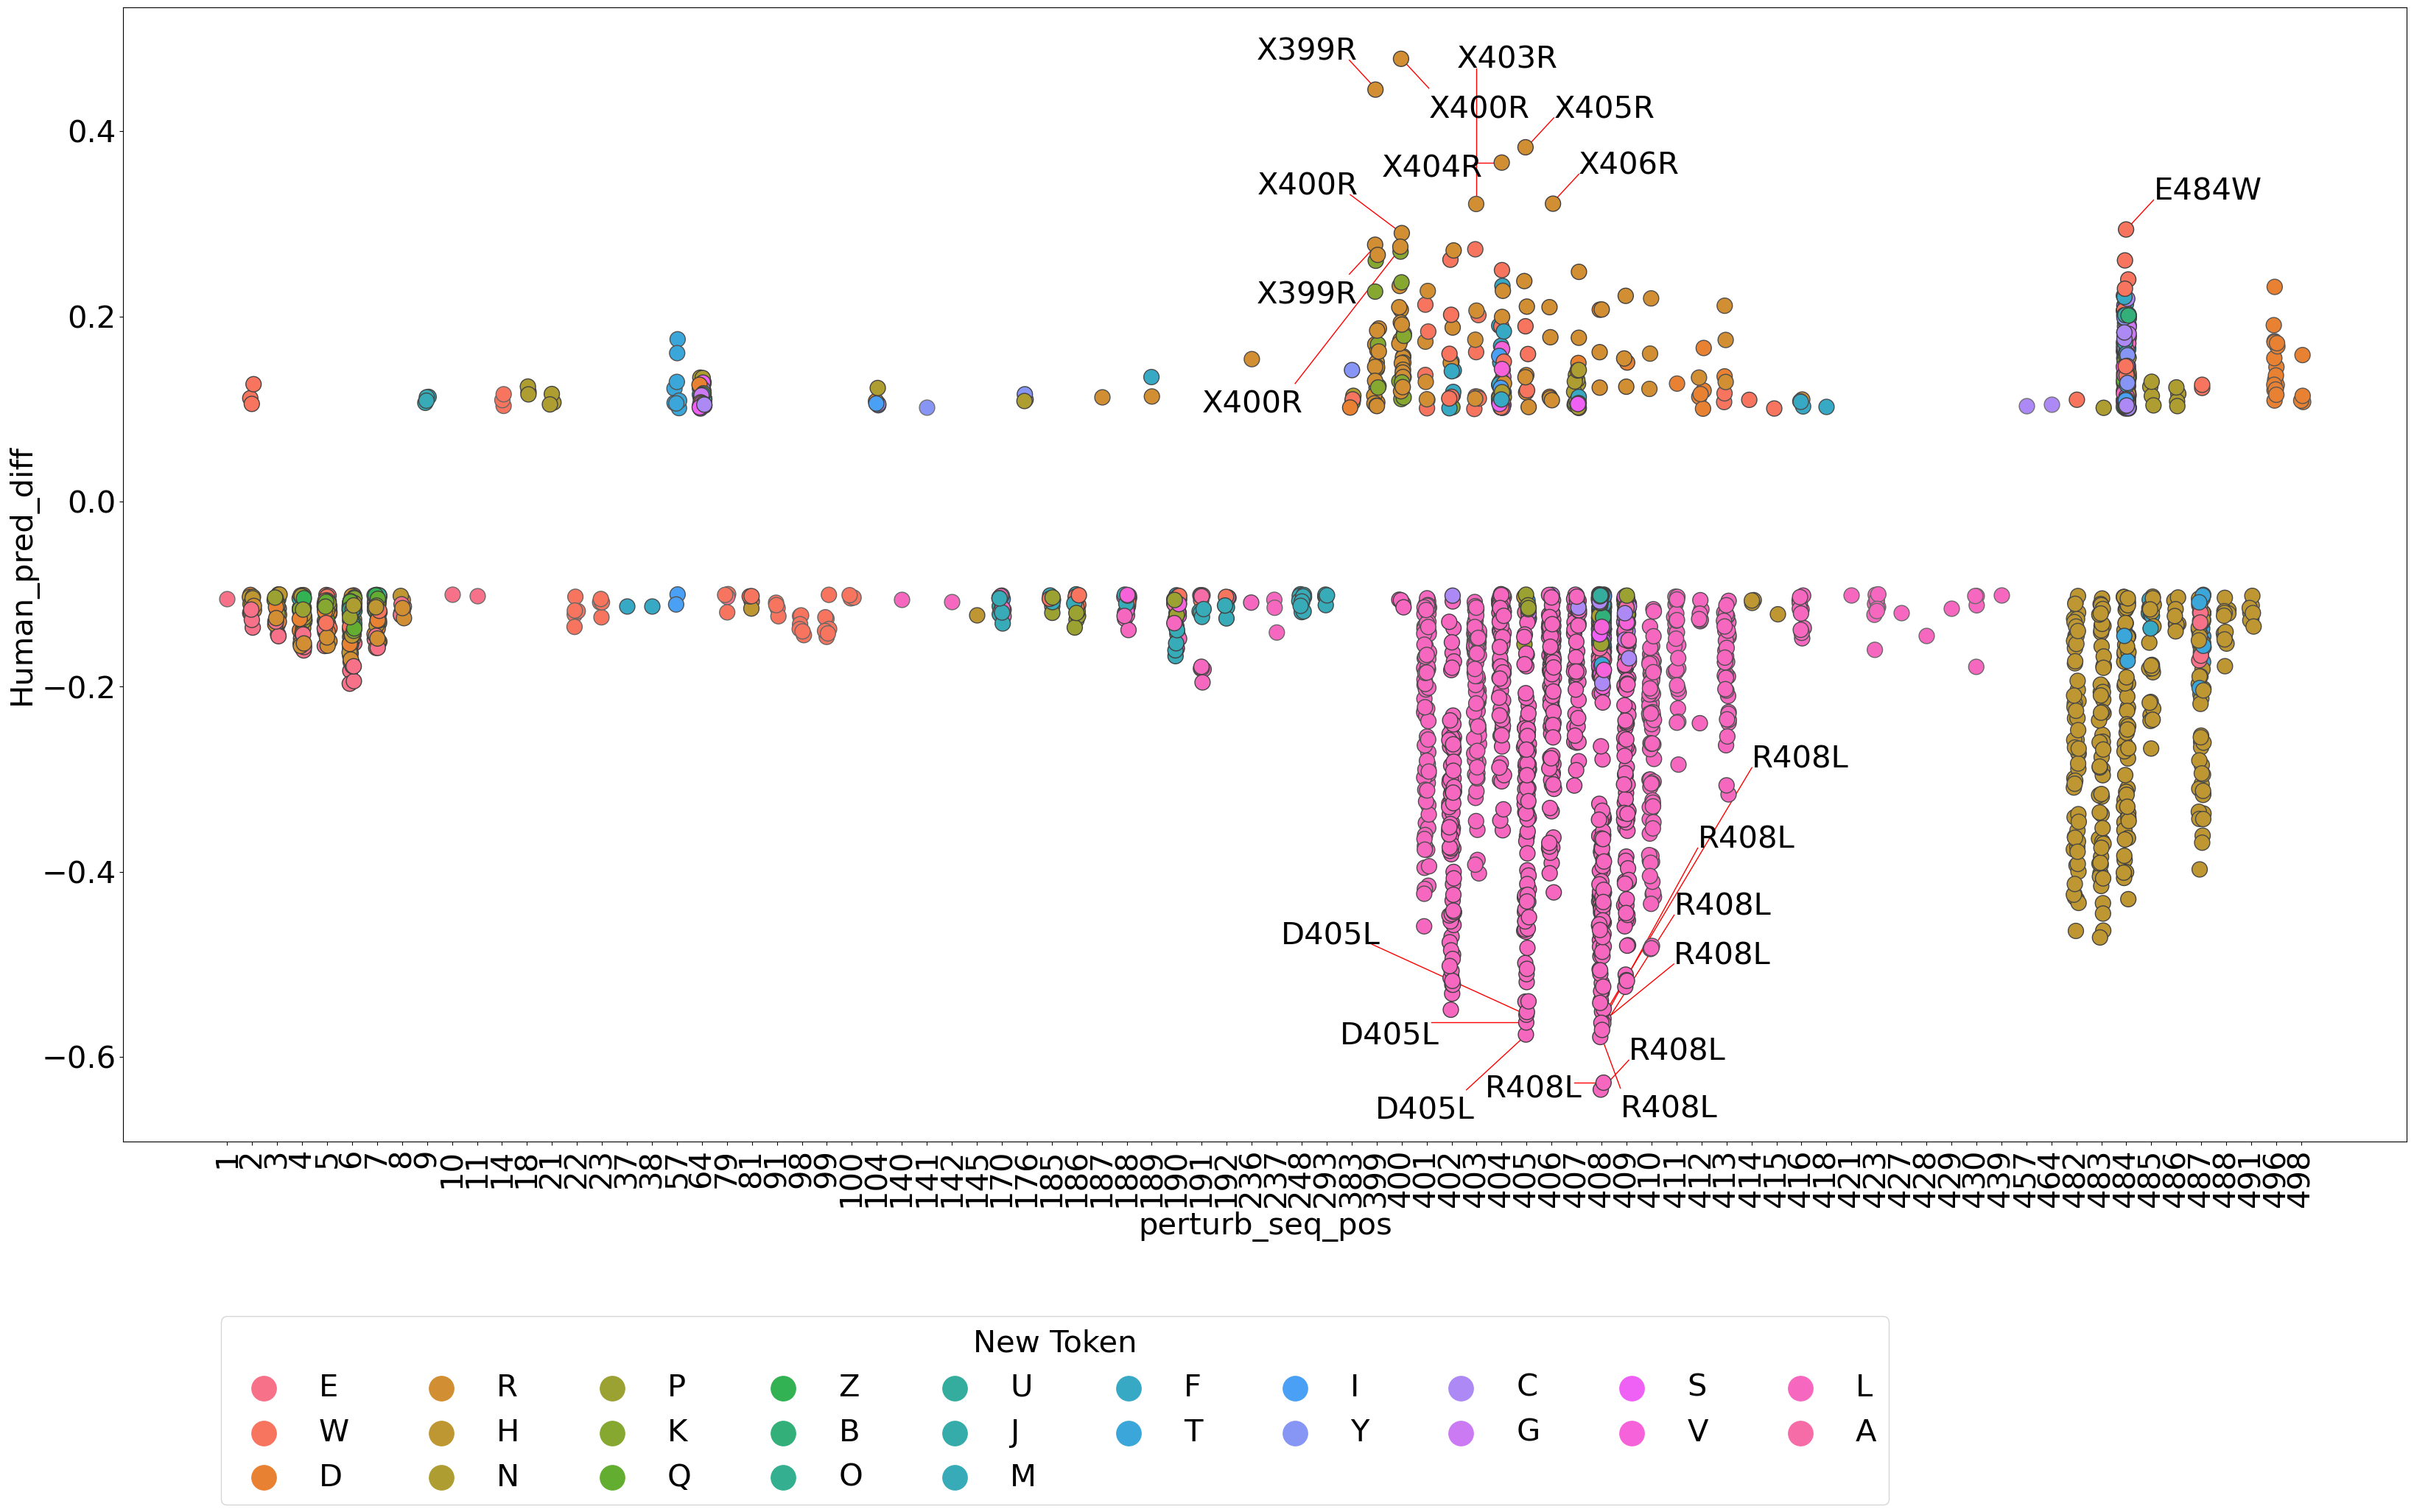

In [31]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [32]:
cut_off_df_2["perturbation_id"].nunique()

425

<Figure size 640x480 with 0 Axes>

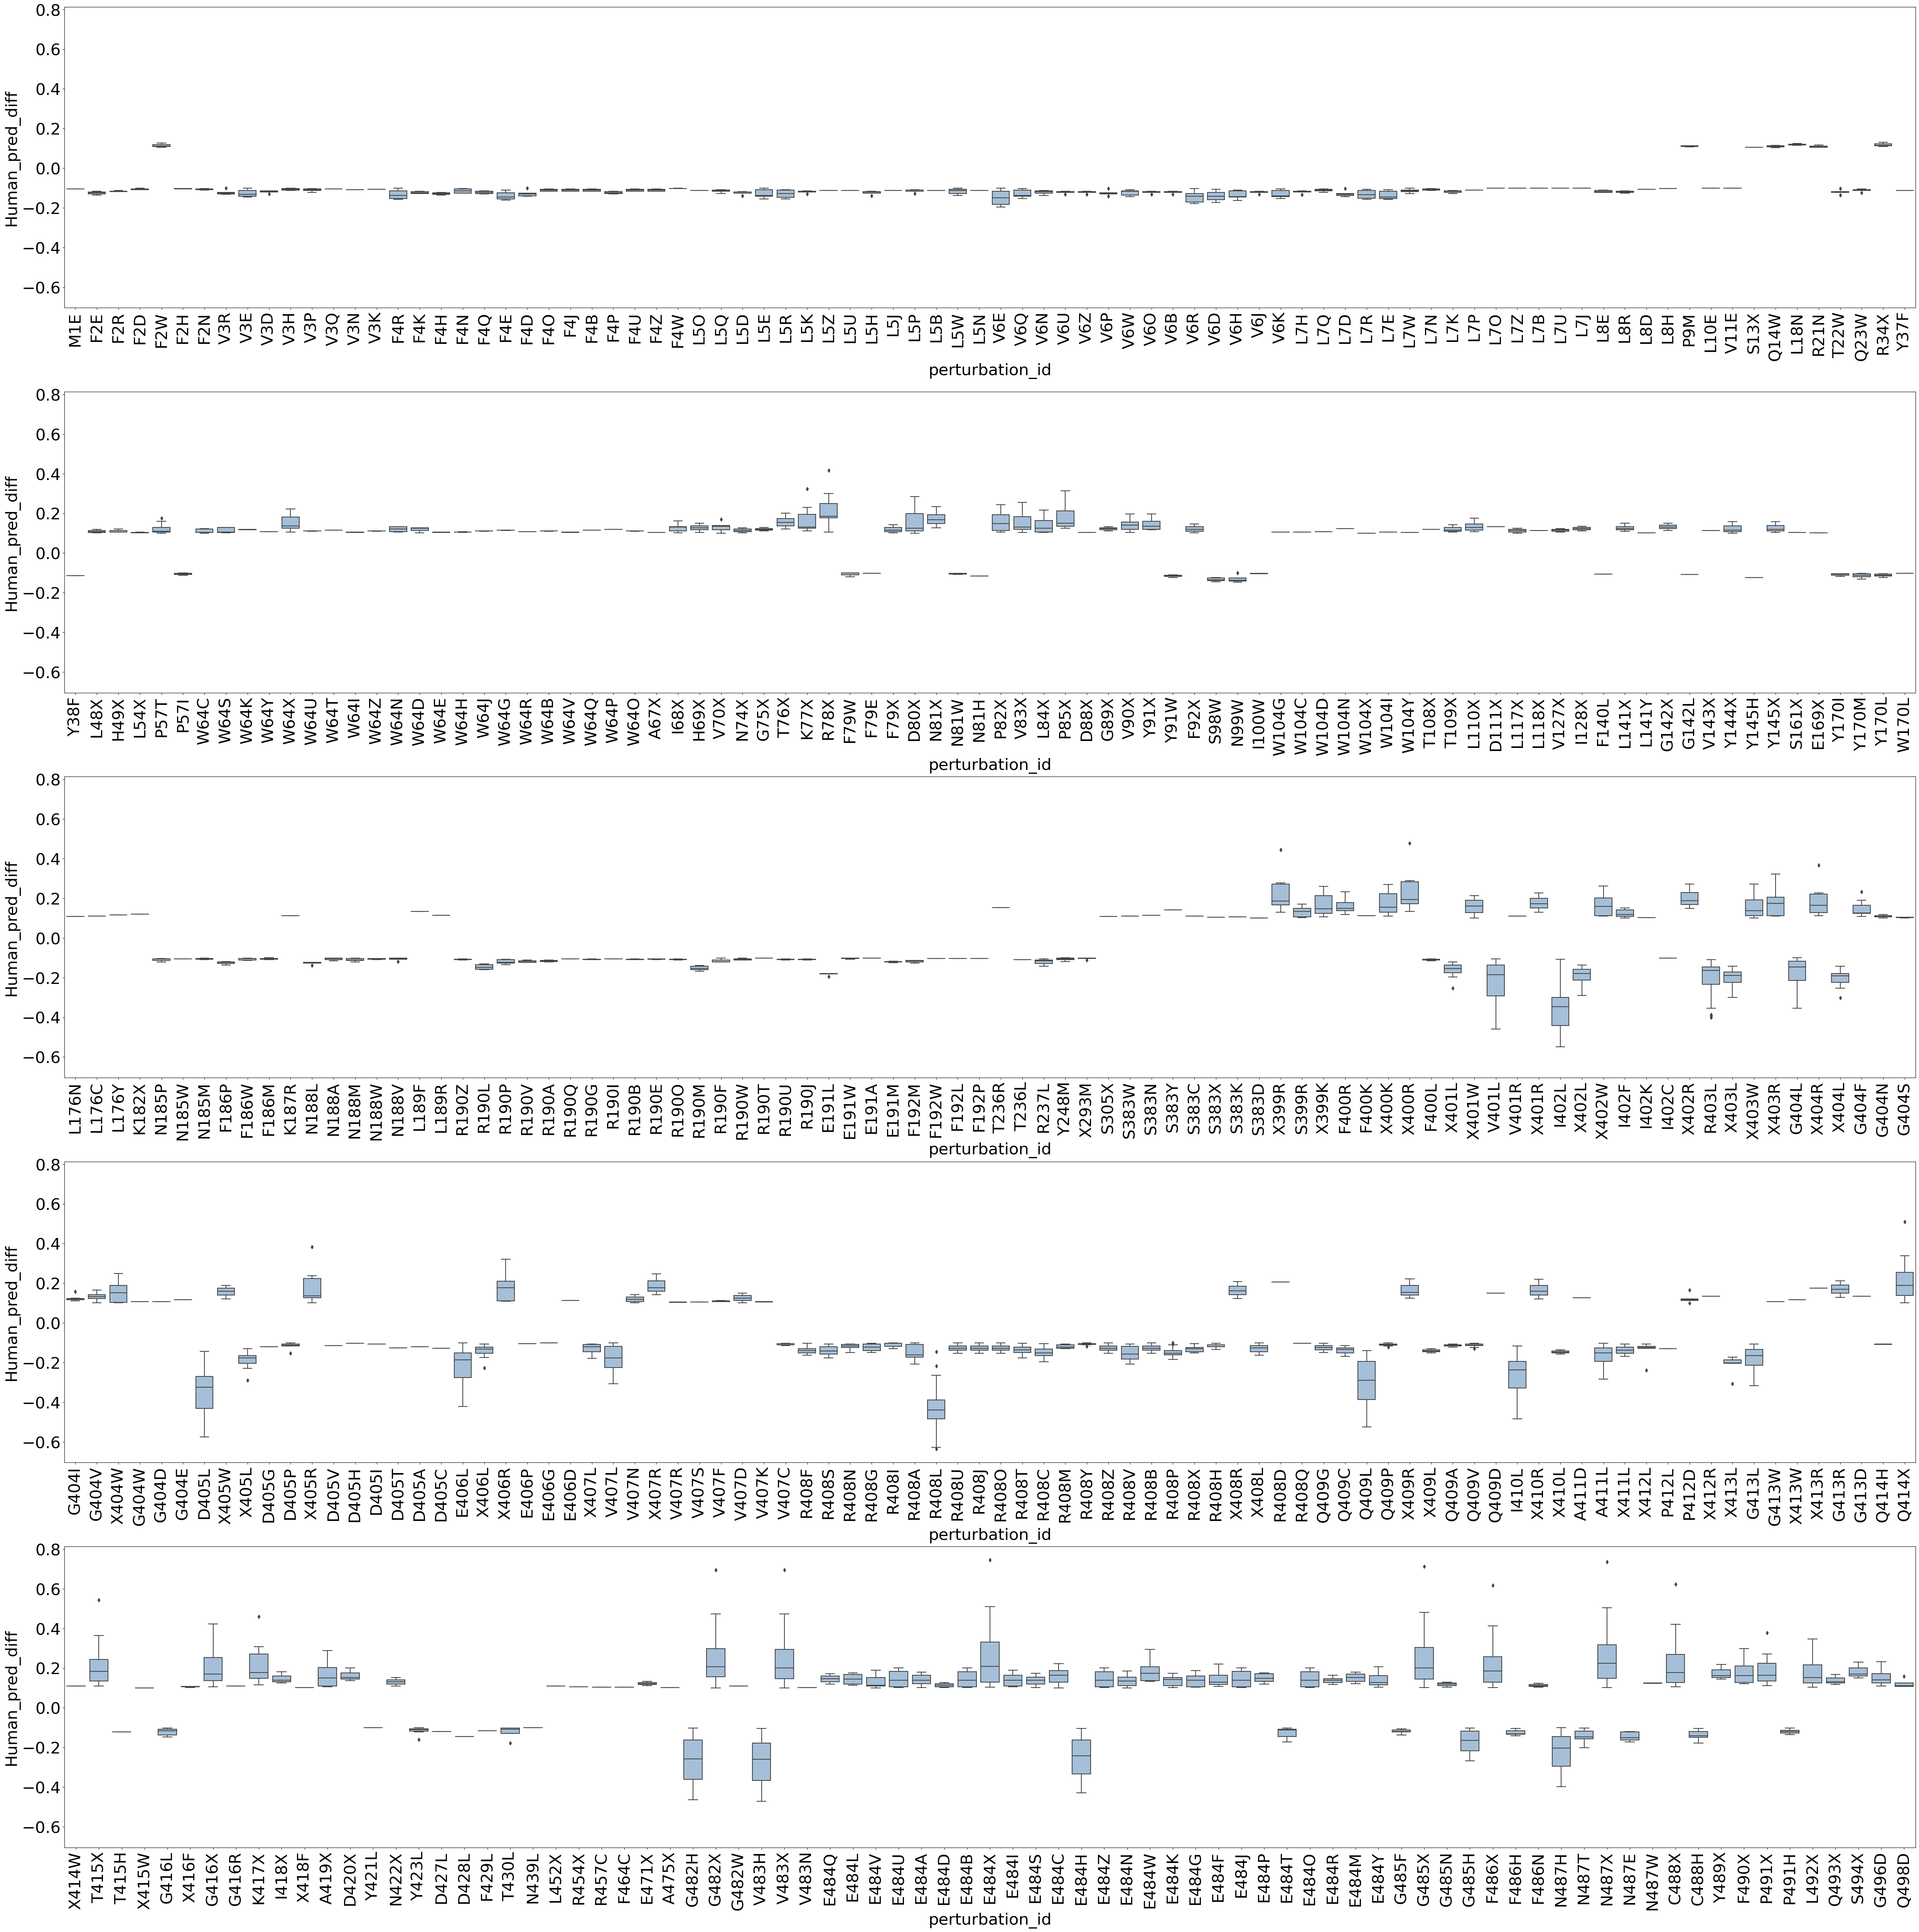

In [33]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(5, 1, figsize=(50, 50), sharex=False, sharey=True)

j = 0
for i in range(0, 426, 86):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(perturbation_ids[i:i+86])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=perturbation_ids[i:i+86],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [34]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

orig_token   pos new_token  Alpha  Delta  XBB perturbation_id
0           T    19         I      0      0    1            T19I
1           T    19         R      0      1    0            T19R
2           L    24         S      0      0    1            L24S
3           A    67         V      0      0    0            A67V
4           V    83         A      0      0    1            V83A
5           T    95         I      0      0    1            T95I
6           G   142         D      0      1    1           G142D
7           H   146         Q      0      0    1           H146Q
8           R   158         G      0      1    0           R158G
9           Q   183         E      0      0    1           Q183E
10          L   212         I      0      0    0           L212I
11          V   213         E      0      0    1           V213E
12          V   213         G      0      0    0           V213G
13          G   339         D      0      0    0           G339D
14          G   339         H      0      0    1           G339H
15          R   346         T      0      0    1           R346T
16          L   368         I      0      0    1           L368I
17          S   371         F      0      0    1           S371F
18          S   371         L      0      0    0           S371L
19          S   373         P      0      0    1           S373P
20          S   375         F      0      0    1           S375F
21          T   376         A      0      0    1           T376A
22          D   405         N      0      0    1           D405N
23          R   408         S      0      0    1           R408S
24          K   417         N      0      0    1           K417N
25          N   440         K      0      0    1           N440K
26          K   444         T      0      0    0           K444T
27          V   445         P      0      0    1           V445P
28          G   446         S      0      0    1           G446S
29          L   452         R      0      1    0           L452R
30          N   460         K      0      0    1           N460K
31          S   477         N      0      0    1           S477N
32          T   478         K      0      1    1           T478K
33          E   484         A      0      0    1           E484A
34          F   486         S      0      0    1           F486S
35          F   486         V      0      0    0           F486V
36          F   490         S      0      0    1           F490S
37          Q   493         R      0      0    0           Q493R
38          G   496         S      0      0    0           G496S
39          Q   498         R      0      0    1           Q498R
40          N   501         Y      1      0    1           N501Y
41          Y   505         H      0      0    1           Y505H
42          T   547         K      0      0    0           T547K
43          A   570         D      1      0    0           A570D
44          D   614         G      1      1    1           D614G
45          H   655         Y      0      0    1           H655Y
46          N   679         K      0      0    1           N679K
47          P   681         H      1      0    1           P681H
48          P   681         R      0      1    0           P681R
49          T   716         I      1      0    0           T716I
50          N   764         K      0      0    1           N764K
51          D   796         Y      0      0    1           D796Y
52          N   856         K      0      0    0           N856K
53          D   950         N      0      1    0           D950N
54          Q   954         H      0      0    1           Q954H
55          N   969         K      0      0    1           N969K
56          L   981         F      0      0    0           L981F
57          S   982         A      1      0    0           S982A
58          D  1118         H      1      0    0          D1118H

In [35]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

/tmp/ipykernel_28019/742767506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


In [36]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

orig_token   pos new_token  Alpha  Delta  XBB perturbation_id  \
0           T    19         I      0      0    1            T19I   
1           T    19         R      0      1    0            T19R   
2           L    24         S      0      0    1            L24S   
3           A    67         V      0      0    0            A67V   
4           V    83         A      0      0    1            V83A   
5           T    95         I      0      0    1            T95I   
6           G   142         D      0      1    1           G142D   
7           H   146         Q      0      0    1           H146Q   
8           R   158         G      0      1    0           R158G   
9           Q   183         E      0      0    1           Q183E   
10          L   212         I      0      0    0           L212I   
11          V   213         E      0      0    1           V213E   
12          V   213         G      0      0    0           V213G   
13          G   339         D      0      0    0           G339D   
14          G   339         H      0      0    1           G339H   
15          R   346         T      0      0    1           R346T   
16          L   368         I      0      0    1           L368I   
17          S   371         F      0      0    1           S371F   
18          S   371         L      0      0    0           S371L   
19          S   373         P      0      0    1           S373P   
20          S   375         F      0      0    1           S375F   
21          T   376         A      0      0    1           T376A   
22          D   405         N      0      0    1           D405N   
23          R   408         S      0      0    1           R408S   
24          K   417         N      0      0    1           K417N   
25          N   440         K      0      0    1           N440K   
26          K   444         T      0      0    0           K444T   
27          V   445         P      0      0    1           V445P   
28          G   446         S      0      0    1           G446S   
29          L   452         R      0      1    0           L452R   
30          N   460         K      0      0    1           N460K   
31          S   477         N      0      0    1           S477N   
32          T   478         K      0      1    1           T478K   
33          E   484         A      0      0    1           E484A   
34          F   486         S      0      0    1           F486S   
35          F   486         V      0      0    0           F486V   
36          F   490         S      0      0    1           F490S   
37          Q   493         R      0      0    0           Q493R   
38          G   496         S      0      0    0           G496S   
39          Q   498         R      0      0    1           Q498R   
40          N   501         Y      1      0    1           N501Y   
41          Y   505         H      0      0    1           Y505H   
42          T   547         K      0      0    0           T547K   
43          A   570         D      1      0    0           A570D   
44          D   614         G      1      1    1           D614G   
45          H   655         Y      0      0    1           H655Y   
46          N   679         K      0      0    1           N679K   
47          P   681         H      1      0    1           P681H   
48          P   681         R      0      1    0           P681R   
49          T   716         I      1      0    0           T716I   
50          N   764         K      0      0    1           N764K   
51          D   796         Y      0      0    1           D796Y   
52          N   856         K      0      0    0           N856K   
53          D   950         N      0      1    0           D950N   
54          Q   954         H      0      0    1           Q954H   
55          N   969         K      0      0    1           N969K   
56          L   981         F      0      0    0           L981F   
57          S   982         A      1      0    0           

<Figure size 640x480 with 0 Axes>

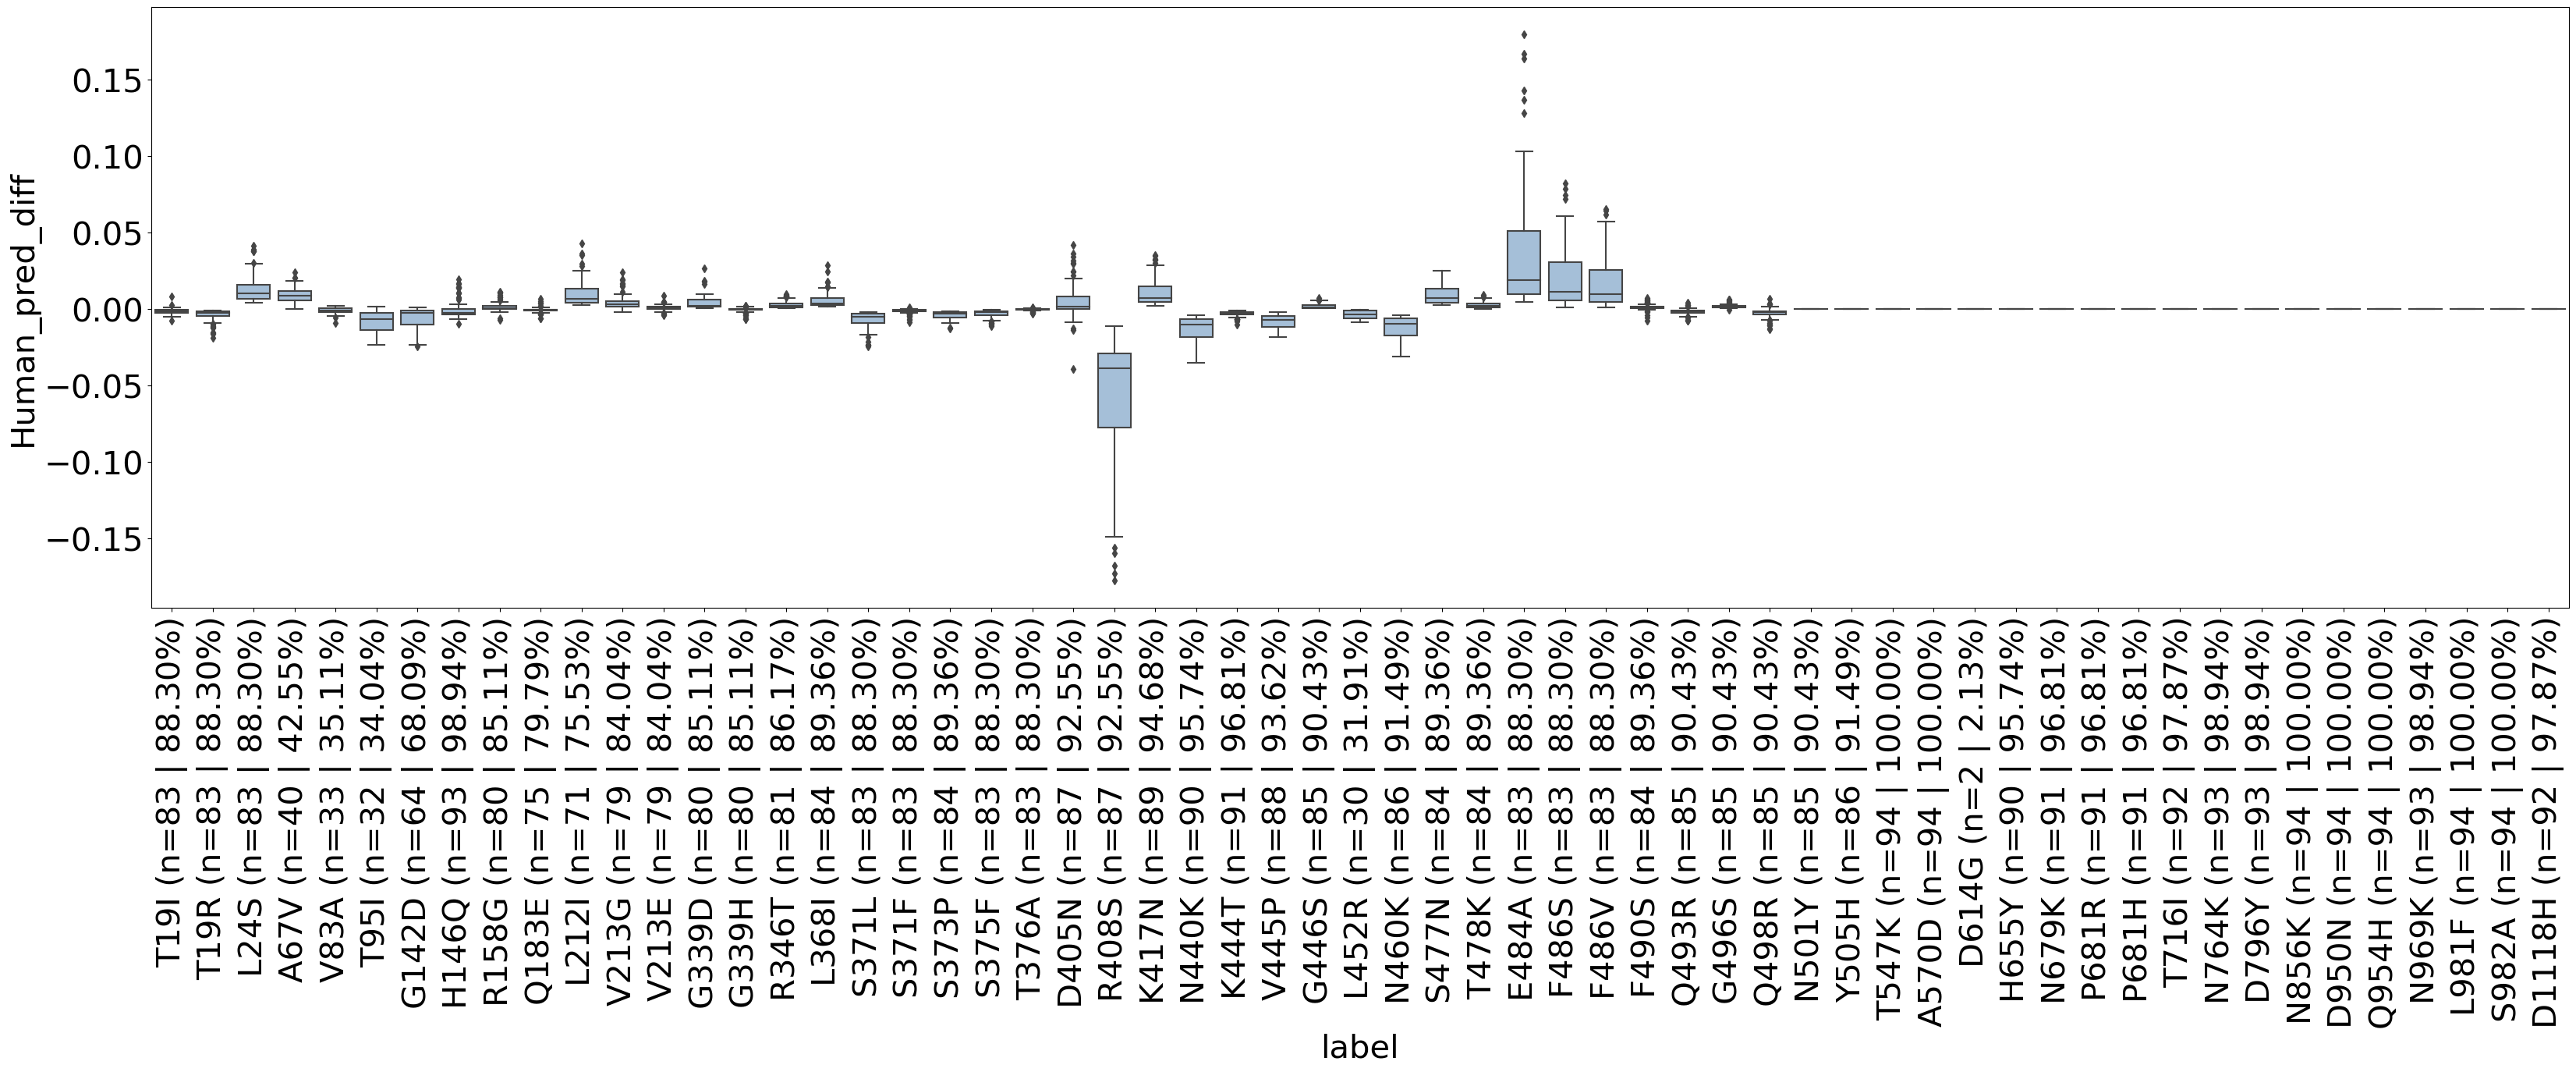

In [37]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [38]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 425
known_mutations = 59
intersection = {'E484A', 'R408S'}


Perturbation id = E484A
E484X
Perturbation id = R408S
R408X


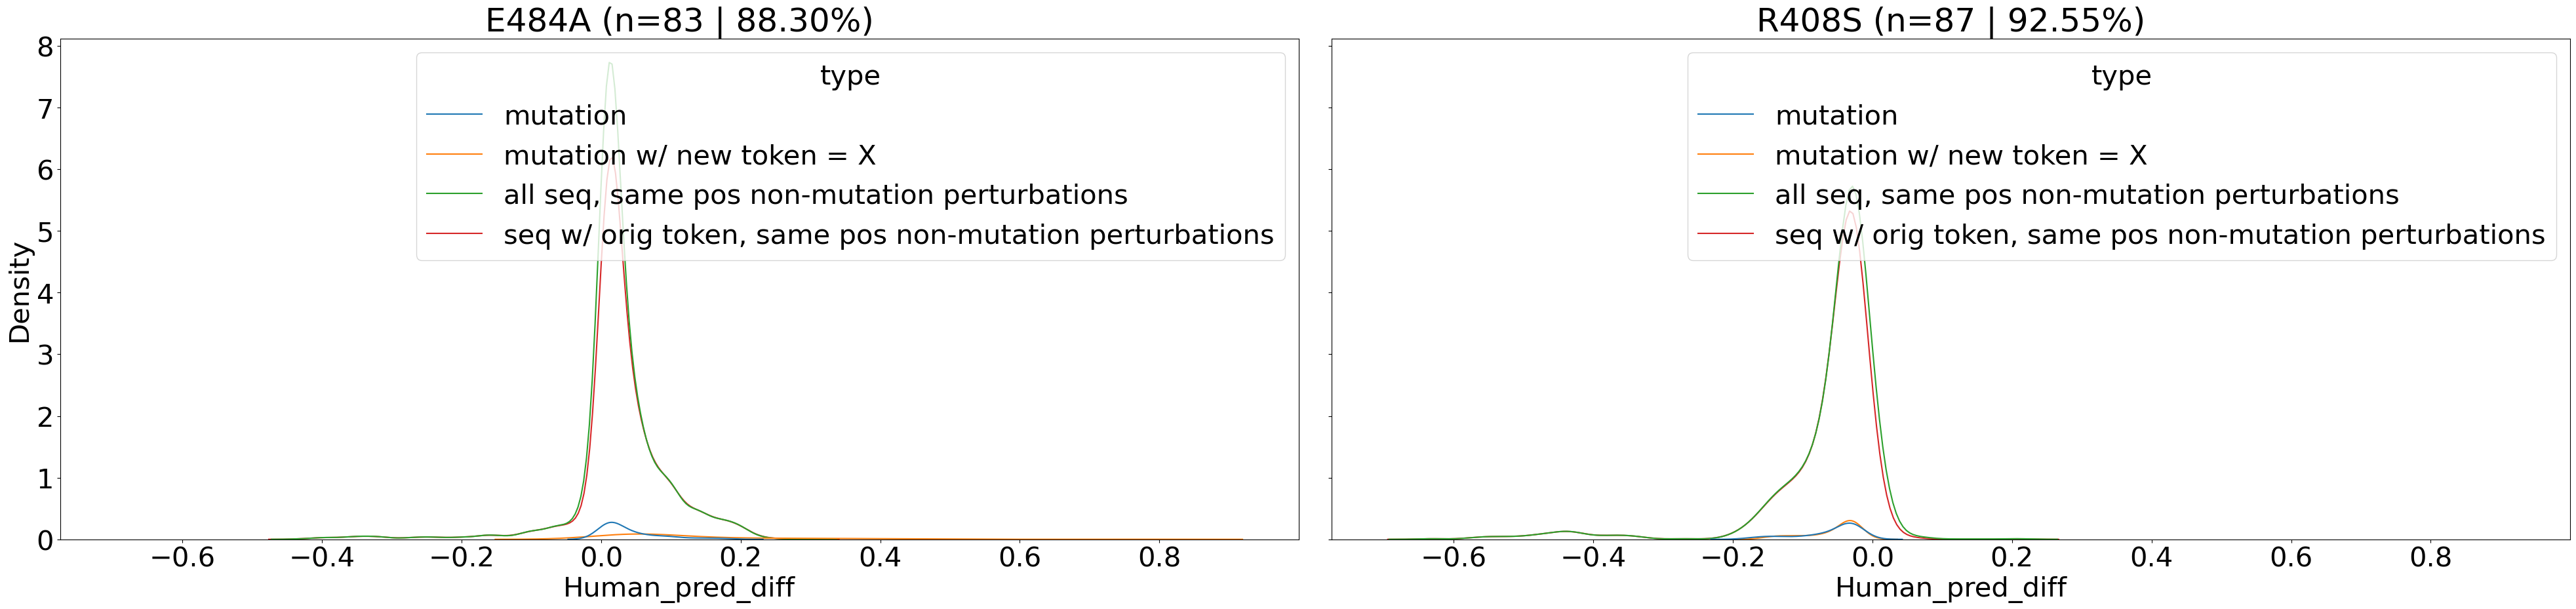

In [54]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

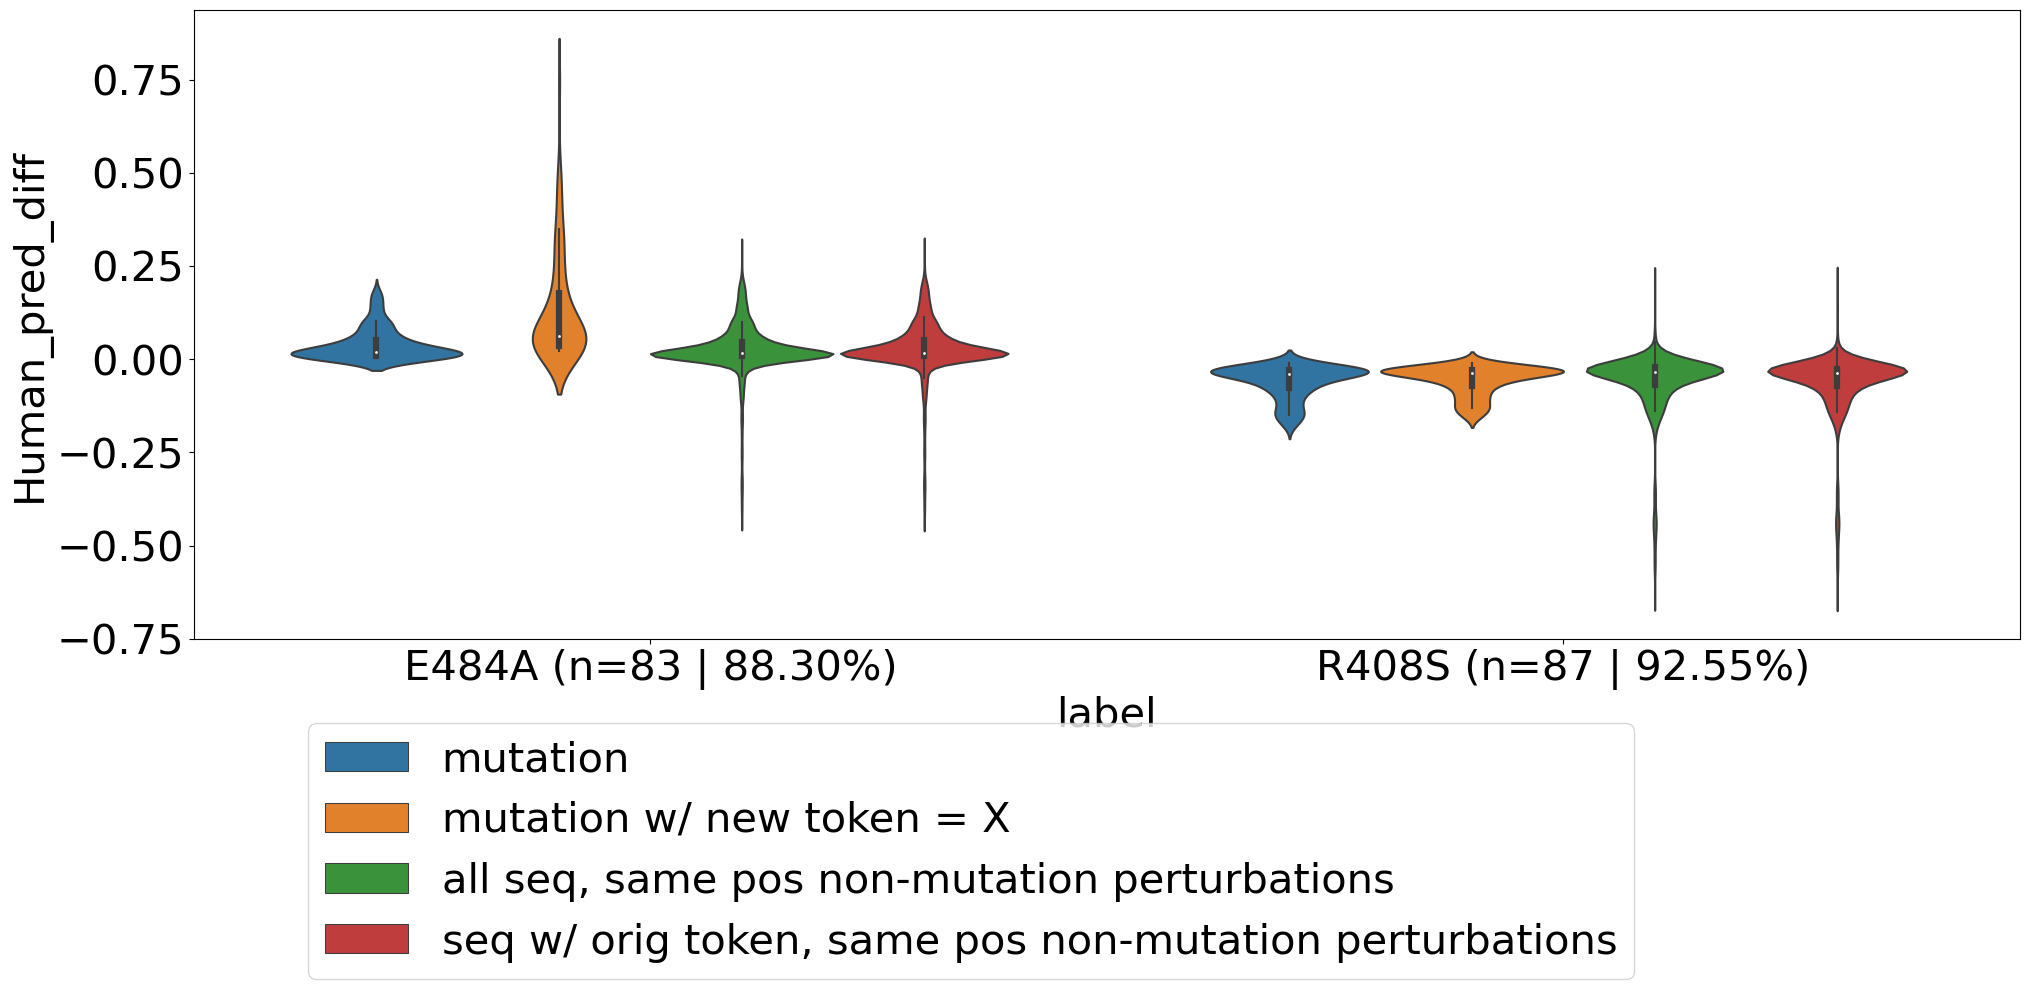

In [55]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

<Figure size 640x480 with 0 Axes>

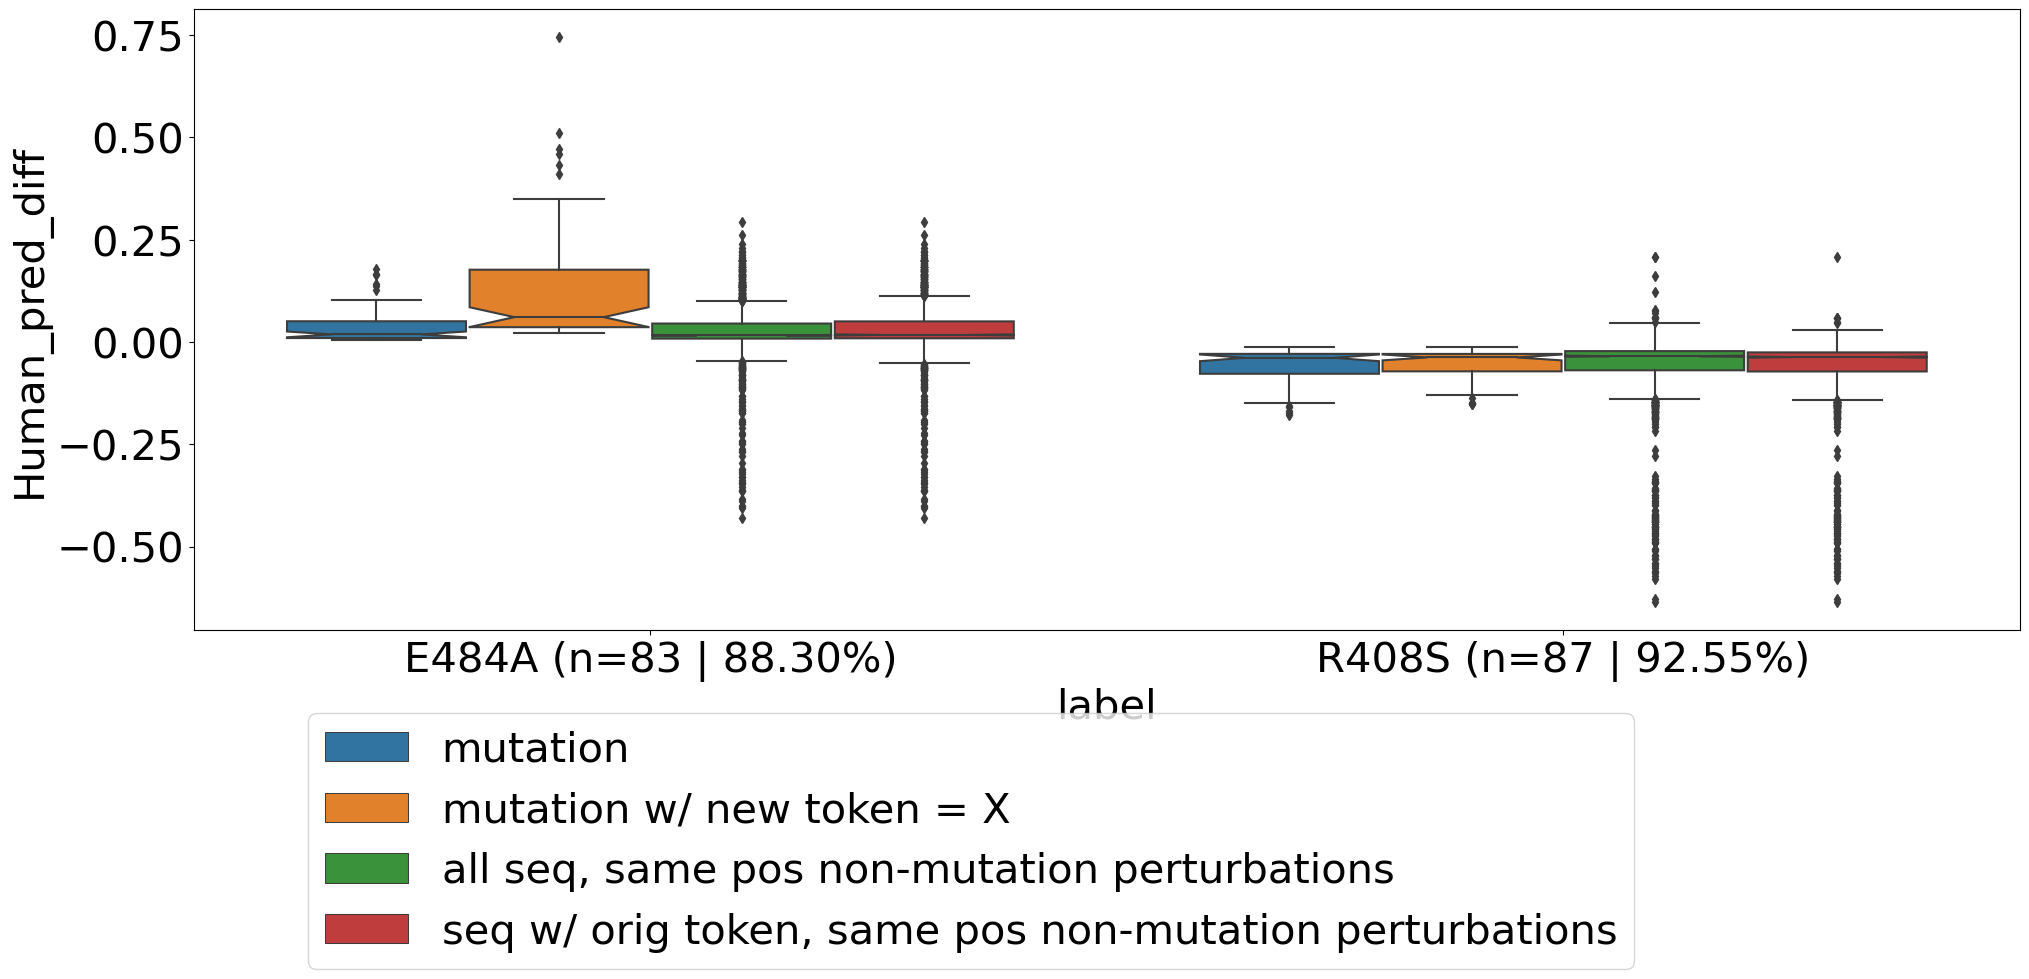

In [56]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [42]:
mutation_mean_diff[mutation_mean_diff["mean_Human_pred_diff"] == 0]

NameError: name 'mutation_mean_diff' is not defined

In [ ]:
mutation_mean_diff_selected = mutation_mean_diff[(mutation_mean_diff["mean_Human_pred_diff"] > 0.1) | (mutation_mean_diff["mean_Human_pred_diff"] < -0.1)].sort_values("mean_Human_pred_diff", ascending=True)
mutation_mean_diff_selected

In [ ]:
perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])]

In [ ]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

data = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])][["perturbation_id", "Human_pred_diff"]]
ax = sns.boxplot(data=data, y="Human_pred_diff", x="perturbation_id", order=mutation_mean_diff_selected["perturbation_id"])
plt.xticks(rotation=90)
plt.show()